# Eye-Tracking Data Analysis for Point Cloud Viewing

This notebook analyzes eye-tracking data collected from participants watching point clouds.

## Data Structure
- JSON files: `GazeData_UserNN_PCName.json`
- Point cloud names: BlueSpin, CasualSquat, FlowerDance, ReadyForWinter
- Frame rate: 25 fps
- Initial 1.5 seconds discarded to account for erratical movements

In [1]:
# Import required libraries
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from glob import glob
import warnings

#warnings.filterwarnings('ignore')

# # Set up plotting style - clean white background
# plt.style.use('default')
# sns.set_style('whitegrid')
# sns.set_palette('husl')
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['axes.grid'] = False

# Create results directory
results_dir = 'Eye_Tracking_Results'
os.makedirs(results_dir, exist_ok=True)

print('Libraries imported and results directory created successfully!')

/home/shivi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Libraries imported and results directory created successfully!


In [2]:
# Configuration parameters
FRAME_RATE = 25  # fps
INITIAL_DISCARD_TIME = 1.5  # 1.5 seconds
INITIAL_DISCARD_FRAMES = 37  # 37 frames because 1.5 seconds * 25 frames is 37.5

# I-VT algorithm parameters
VELOCITY_THRESHOLD_HEAD = 0.1  # m/s for head movement
VELOCITY_THRESHOLD_GAZE = 30  # degrees/s for gaze movement

# Color configuration for movement categories
CATEGORY_COLORS = {'Low': '#1f77b4', 'Medium': '#2ca02c', 'High': '#ff7f0e'}

# Category order for consistent plotting
CATEGORY_ORDER = ['Low', 'Medium', 'High']

print(f'Configuration:')
print(f'- Frame rate: {FRAME_RATE} fps')
print(f'- Initial discard: {INITIAL_DISCARD_TIME}s ({INITIAL_DISCARD_FRAMES} frames)')
print(f'- Head velocity threshold: {VELOCITY_THRESHOLD_HEAD} m/s')
print(f'- Gaze velocity threshold: {VELOCITY_THRESHOLD_GAZE} deg/s')
print(f'- Category colors: {CATEGORY_COLORS}')

Configuration:
- Frame rate: 25 fps
- Initial discard: 1.5s (37 frames)
- Head velocity threshold: 0.1 m/s
- Gaze velocity threshold: 30 deg/s
- Category colors: {'Low': '#1f77b4', 'Medium': '#2ca02c', 'High': '#ff7f0e'}


In [3]:
def load_eye_tracking_data(data_dir='Eye_Tracking_JSON'):
    """
    Load all eye-tracking JSON files from the specified directory.
    """
    all_data = []

    # Find all JSON files matching the pattern
    json_files = glob(os.path.join(data_dir, 'GazeData_User*_*.json'))

    print(f'Found {len(json_files)} JSON files')

    for file_path in json_files:
        # Extract participant ID and PC name from filename
        filename = os.path.basename(file_path)
        parts = filename.replace('.json', '').split('_')
        participant_id = parts[1].replace('User', '')
        pc_name = parts[2]

        # Load JSON data
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()

            if len(lines) != 500:
                print('Uneven number of lines for ' + file_path + ' with ' + str(len(lines)))

            # Parse each line as JSON
            session_data = []
            for line in lines:
                if line.strip():
                    data_point = json.loads(line.strip())
                    session_data.append(data_point)

            # Convert to DataFrame and add metadata
            df = pd.DataFrame(session_data)
            corrected_participant_id = int(participant_id) - 51
            if corrected_participant_id > 15:
                corrected_participant_id -= 1
            corrected_participant_id += 1
            df['participant_id'] = corrected_participant_id

            df['pc_name'] = pc_name
            df['frame_index'] = range(len(df))
            df['time_seconds'] = df['frame_index'] / FRAME_RATE

            # Remove initial frames
            df = df[df['frame_index'] >= INITIAL_DISCARD_FRAMES].copy()
            df = df.reset_index(drop=True)

            all_data.append(df)

        except Exception as e:
            print(f'Error loading {file_path}: {e}')

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    print(f'Loaded data for {combined_df["participant_id"].nunique()} participants')
    print(f'Point clouds: {combined_df["pc_name"].unique()}')
    print(f'Total data points after filtering: {len(combined_df)}')

    return combined_df


# Load the data
df = load_eye_tracking_data()
df.head()

Found 164 JSON files
Uneven number of lines for Eye_Tracking_JSON/GazeData_User76_PCReadyForWinter.json with 162
Loaded data for 41 participants
Point clouds: ['PCBlueSpin' 'PCCasualSquat' 'PCFlowerDance' 'PCReadyForWinter']
Total data points after filtering: 75594


pcName  pcFrameIndex  gazeOriginX  gazeOriginY  gazeOriginZ  \
0  BlueSpin            36     0.364907     0.080448     0.237398   
1  BlueSpin            37     0.365488     0.081867     0.238323   
2  BlueSpin            38     0.365727     0.081866     0.238407   
3  BlueSpin            39     0.366281     0.081813     0.238656   
4  BlueSpin            40     0.366827     0.081719     0.238914   

   gazeDirectionNormalisedX  gazeDirectionNormalisedY  \
0                 -0.062045                  0.055913   
1                 -0.130558                  0.061773   
2                 -0.131540                  0.061959   
3                 -0.134013                  0.062498   
4                 -0.136212                  0.062915   

   gazeDirectionNormalisedZ  pcWorldPositionX  pcWorldPositionY  \
0                  0.996506               0.0              -1.5   
1                  0.989514               0.0              -1.5   
2                  0.989373               0.0              -1.5   
3                  0.989007               0.0              -1.5   
4                  0.988680               0.0              -1.5   

   pcWorldPositionZ  objectRotationY  userId  participant_id     pc_name  \
0               2.2             90.0      51               1  PCBlueSpin   
1               2.2             90.0      51               1  PCBlueSpin   
2               2.2             90.0      51               1  PCBlueSpin   
3               2.2             90.0      51               1  PCBlueSpin   
4               2.2             90.0      51               1  PCBlueSpin   

   frame_index  time_seconds  
0           37          1.48  
1           38          1.52  
2           39          1.56  
3           40          1.60  
4           41          1.64

In [4]:
def calculate_movement_velocities(df):
    """
    Calculate head and gaze movement velocities using I-VT algorithm.
    """
    results = []

    # Process each participant-PC combination separately
    for (participant_id, pc_name), group in df.groupby(['participant_id', 'pc_name']):
        group = group.sort_values('frame_index').reset_index(drop=True)

        # Calculate head position changes
        head_positions = group[['gazeOriginX', 'gazeOriginY', 'gazeOriginZ']].values
        head_diff = np.diff(head_positions, axis=0)
        head_distances = np.sqrt(np.sum(head_diff**2, axis=1))  # Euclidean distance in meters
        head_velocities = head_distances * FRAME_RATE  # Convert to m/s

        # Calculate gaze direction changes (angular velocity)
        gaze_directions = group[
            ['gazeDirectionNormalisedX', 'gazeDirectionNormalisedY', 'gazeDirectionNormalisedZ']
        ].values

        # Calculate angular differences between consecutive gaze vectors
        gaze_angular_diffs = []
        for i in range(1, len(gaze_directions)):
            v1 = gaze_directions[i - 1]
            v2 = gaze_directions[i]
            # Normalize vectors
            v1_norm = v1 / np.linalg.norm(v1)
            v2_norm = v2 / np.linalg.norm(v2)
            # Calculate angle between vectors in radians
            dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
            angle_rad = np.arccos(dot_product)
            angle_deg = np.degrees(angle_rad)
            gaze_angular_diffs.append(angle_deg)

        gaze_angular_velocities = np.array(gaze_angular_diffs) * FRAME_RATE  # Convert to deg/s

        # Create results for each second
        max_time = group['time_seconds'].max()

        for second in range(int(max_time) + 1):
            # Find frames in this second
            start_time = second
            end_time = second + 1

            mask = (group['time_seconds'] >= start_time) & (group['time_seconds'] < end_time)
            frames_in_second = np.where(mask)[0]

            if len(frames_in_second) > 1:
                # Get velocities for this second (excluding the first frame since we need differences)
                valid_head_indices = frames_in_second[frames_in_second > 0] - 1
                valid_gaze_indices = frames_in_second[frames_in_second > 0] - 1

                if len(valid_head_indices) > 0:
                    head_vel_second = np.mean(head_velocities[valid_head_indices])
                    gaze_vel_second = np.mean(gaze_angular_velocities[valid_gaze_indices])

                    results.append(
                        {
                            'participant_id': participant_id,
                            'pc_name': pc_name,
                            'second': second,
                            'head_velocity_m_per_s': head_vel_second,
                            'gaze_velocity_deg_per_s': gaze_vel_second,
                        }
                    )

    return pd.DataFrame(results)


# Calculate movement velocities
velocity_df = calculate_movement_velocities(df)
print(f'Calculated velocities for {len(velocity_df)} second-intervals')
print(
    f'Head velocity range: {velocity_df["head_velocity_m_per_s"].min():.4f} - {velocity_df["head_velocity_m_per_s"].max():.4f} m/s'
)
print(
    f'Gaze velocity range: {velocity_df["gaze_velocity_deg_per_s"].min():.4f} - {velocity_df["gaze_velocity_deg_per_s"].max():.4f} deg/s'
)

velocity_df.head()

Calculated velocities for 3103 second-intervals
Head velocity range: 0.0036 - 6.3352 m/s
Gaze velocity range: 0.5561 - 636.8716 deg/s


participant_id     pc_name  second  head_velocity_m_per_s  \
0               1  PCBlueSpin       1               0.024504   
1               1  PCBlueSpin       2               0.250724   
2               1  PCBlueSpin       3               1.085552   
3               1  PCBlueSpin       4               0.234695   
4               1  PCBlueSpin       5               0.610607   

   gaze_velocity_deg_per_s  
0                13.242118  
1                11.444521  
2                83.126194  
3                12.767400  
4                37.148299

In [5]:
velocity_df

participant_id           pc_name  second  head_velocity_m_per_s  \
0                  1        PCBlueSpin       1               0.024504   
1                  1        PCBlueSpin       2               0.250724   
2                  1        PCBlueSpin       3               1.085552   
3                  1        PCBlueSpin       4               0.234695   
4                  1        PCBlueSpin       5               0.610607   
...              ...               ...     ...                    ...   
3098              41  PCReadyForWinter      15               0.457932   
3099              41  PCReadyForWinter      16               0.441404   
3100              41  PCReadyForWinter      17               0.577274   
3101              41  PCReadyForWinter      18               0.440559   
3102              41  PCReadyForWinter      19               0.244086   

      gaze_velocity_deg_per_s  
0                   13.242118  
1                   11.444521  
2                   83.126194  
3                   12.767400  
4                   37.148299  
...                       ...  
3098                20.030261  
3099                18.020977  
3100                13.929692  
3101                17.335719  
3102                11.294431  

[3103 rows x 5 columns]

In [6]:
def filter_outliers_iqr(df, columns, k=1.5):
    """
    Filter outliers using the Interquartile Range (IQR) method.

    Parameters:
    - df: DataFrame
    - columns: list of column names to apply IQR filtering
    - k: IQR multiplier (default 1.5, standard outlier detection)

    Returns:
    - DataFrame with outliers removed
    - Dictionary with outlier statistics
    """
    outlier_stats = {}
    df_filtered = df.copy()

    for col in columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Count outliers
        outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        n_outliers = outliers_mask.sum()
        n_total = len(df)

        # Store statistics
        outlier_stats[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'n_outliers': n_outliers,
            'n_total': n_total,
            'outlier_percentage': (n_outliers / n_total) * 100,
        }

        # Filter outliers
        df_filtered = df_filtered[
            (df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)
        ]

        print(f'{col}:')
        print(f'  Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}')
        print(f'  Bounds: [{lower_bound:.4f}, {upper_bound:.4f}]')
        print(f'  Outliers removed: {n_outliers}/{n_total} ({n_outliers / n_total * 100:.2f}%)')
        print()

    print(f'Total data points before filtering: {len(df)}')
    print(f'Total data points after filtering: {len(df_filtered)}')
    print(f'Overall data retained: {len(df_filtered) / len(df) * 100:.2f}%')

    return df_filtered, outlier_stats


# Apply IQR filtering to remove outliers
print('Applying IQR outlier filtering...')
print('=' * 50)

velocity_df_filtered, outlier_statistics = filter_outliers_iqr(
    velocity_df,
    ['head_velocity_m_per_s', 'gaze_velocity_deg_per_s'],
    k=1.5,  # Standard IQR multiplier
)

# Update the main velocity dataframe to use filtered data
velocity_df = velocity_df_filtered.copy()

print('=' * 50)
print(f'Filtered velocity ranges:')
print(
    f'Head velocity: {velocity_df["head_velocity_m_per_s"].min():.4f} - {velocity_df["head_velocity_m_per_s"].max():.4f} m/s'
)
print(
    f'Gaze velocity: {velocity_df["gaze_velocity_deg_per_s"].min():.4f} - {velocity_df["gaze_velocity_deg_per_s"].max():.4f} deg/s'
)

Applying IQR outlier filtering...
head_velocity_m_per_s:
  Q1: 0.2163, Q3: 0.8051, IQR: 0.5888
  Bounds: [-0.6668, 1.6882]
  Outliers removed: 173/3103 (5.58%)

gaze_velocity_deg_per_s:
  Q1: 19.5083, Q3: 114.0692, IQR: 94.5608
  Bounds: [-122.3329, 255.9104]
  Outliers removed: 124/3103 (4.00%)

Total data points before filtering: 3103
Total data points after filtering: 2857
Overall data retained: 92.07%
Filtered velocity ranges:
Head velocity: 0.0036 - 1.6846 m/s
Gaze velocity: 0.5561 - 254.2993 deg/s


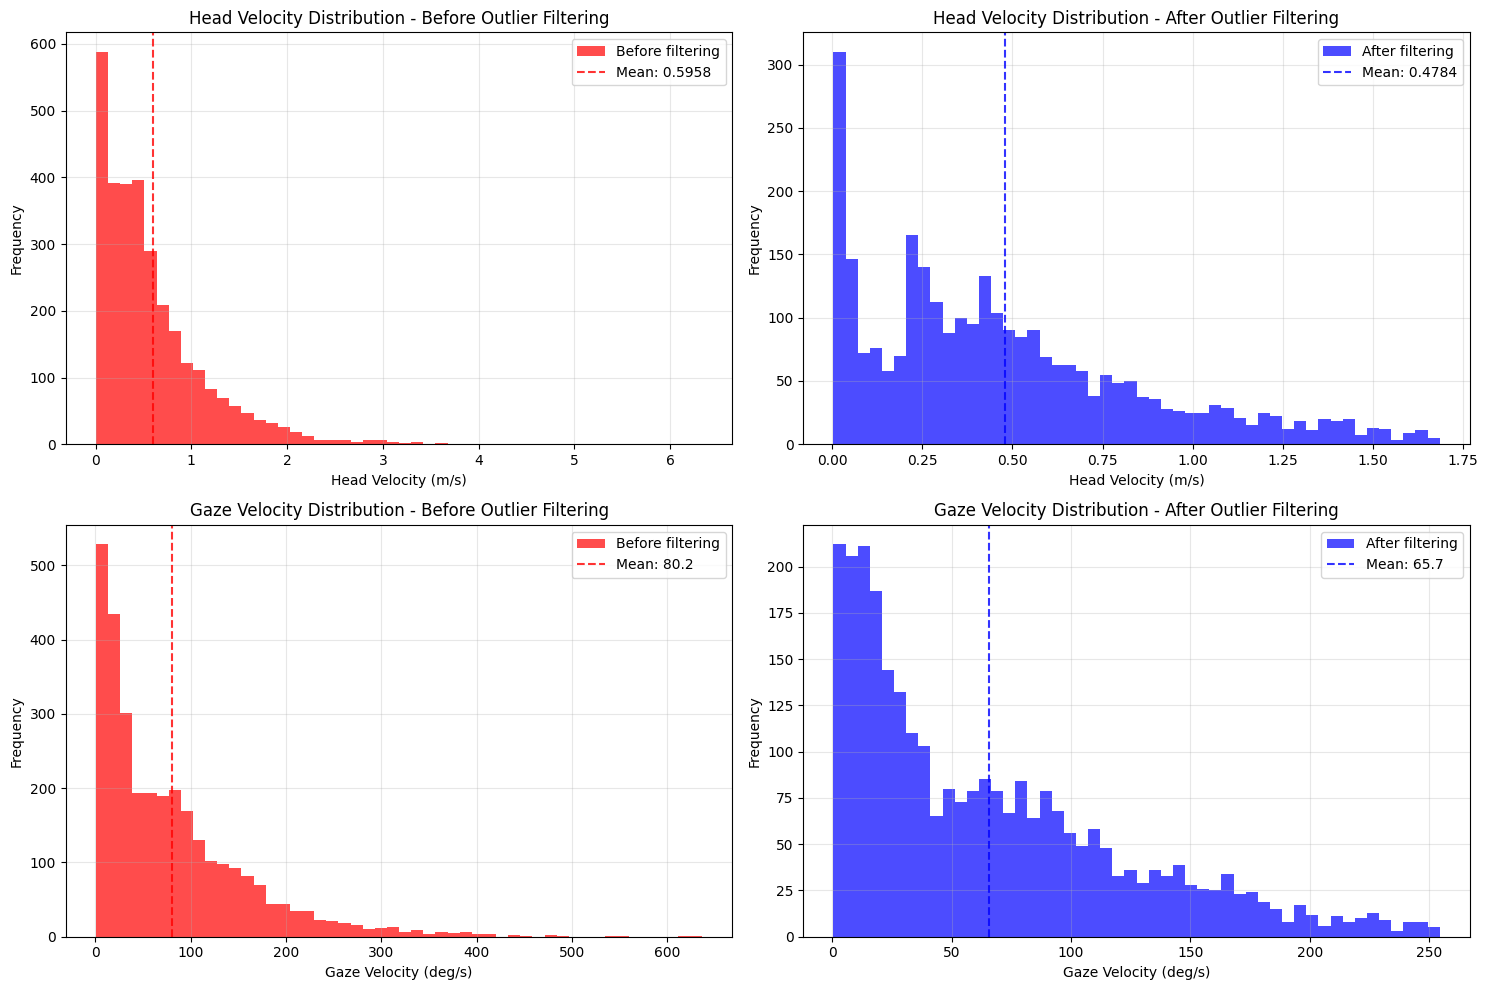

OUTLIER FILTERING IMPACT SUMMARY:
HEAD VELOCITY:
  Before filtering: Mean = 0.5958 ± 0.5876 m/s
  After filtering:  Mean = 0.4784 ± 0.3852 m/s
  Range before: 0.0036 - 6.3352 m/s
  Range after:  0.0036 - 1.6846 m/s

GAZE VELOCITY:
  Before filtering: Mean = 80.2 ± 79.4 deg/s
  After filtering:  Mean = 65.7 ± 57.4 deg/s
  Range before: 0.6 - 636.9 deg/s
  Range after:  0.6 - 254.3 deg/s

DATA POINTS:
  Original: 3,103 data points
  Filtered: 2,857 data points
  Retained: 92.07%


In [7]:
# Visualize the effect of outlier filtering
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Load original data for comparison (before filtering)
velocity_df_original = calculate_movement_velocities(df)

# Head velocity - Before filtering
axes[0, 0].hist(
    velocity_df_original['head_velocity_m_per_s'],
    bins=50,
    alpha=0.7,
    color='red',
    label='Before filtering',
)
axes[0, 0].axvline(
    velocity_df_original['head_velocity_m_per_s'].mean(),
    color='red',
    linestyle='--',
    alpha=0.8,
    label=f'Mean: {velocity_df_original["head_velocity_m_per_s"].mean():.4f}',
)
axes[0, 0].set_title('Head Velocity Distribution - Before Outlier Filtering')
axes[0, 0].set_xlabel('Head Velocity (m/s)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Head velocity - After filtering
axes[0, 1].hist(
    velocity_df['head_velocity_m_per_s'], bins=50, alpha=0.7, color='blue', label='After filtering'
)
axes[0, 1].axvline(
    velocity_df['head_velocity_m_per_s'].mean(),
    color='blue',
    linestyle='--',
    alpha=0.8,
    label=f'Mean: {velocity_df["head_velocity_m_per_s"].mean():.4f}',
)
axes[0, 1].set_title('Head Velocity Distribution - After Outlier Filtering')
axes[0, 1].set_xlabel('Head Velocity (m/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gaze velocity - Before filtering
axes[1, 0].hist(
    velocity_df_original['gaze_velocity_deg_per_s'],
    bins=50,
    alpha=0.7,
    color='red',
    label='Before filtering',
)
axes[1, 0].axvline(
    velocity_df_original['gaze_velocity_deg_per_s'].mean(),
    color='red',
    linestyle='--',
    alpha=0.8,
    label=f'Mean: {velocity_df_original["gaze_velocity_deg_per_s"].mean():.1f}',
)
axes[1, 0].set_title('Gaze Velocity Distribution - Before Outlier Filtering')
axes[1, 0].set_xlabel('Gaze Velocity (deg/s)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gaze velocity - After filtering
axes[1, 1].hist(
    velocity_df['gaze_velocity_deg_per_s'],
    bins=50,
    alpha=0.7,
    color='blue',
    label='After filtering',
)
axes[1, 1].axvline(
    velocity_df['gaze_velocity_deg_per_s'].mean(),
    color='blue',
    linestyle='--',
    alpha=0.8,
    label=f'Mean: {velocity_df["gaze_velocity_deg_per_s"].mean():.1f}',
)
axes[1, 1].set_title('Gaze Velocity Distribution - After Outlier Filtering')
axes[1, 1].set_xlabel('Gaze Velocity (deg/s)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'outlier_filtering_comparison.pdf'), dpi=300, bbox_inches='tight'
)
plt.savefig(
    os.path.join(results_dir, 'outlier_filtering_comparison.png'), dpi=300, bbox_inches='tight'
)
plt.show()

# Print summary statistics comparison
print('OUTLIER FILTERING IMPACT SUMMARY:')
print('=' * 60)
print('HEAD VELOCITY:')
print(
    f'  Before filtering: Mean = {velocity_df_original["head_velocity_m_per_s"].mean():.4f} ± {velocity_df_original["head_velocity_m_per_s"].std():.4f} m/s'
)
print(
    f'  After filtering:  Mean = {velocity_df["head_velocity_m_per_s"].mean():.4f} ± {velocity_df["head_velocity_m_per_s"].std():.4f} m/s'
)
print(
    f'  Range before: {velocity_df_original["head_velocity_m_per_s"].min():.4f} - {velocity_df_original["head_velocity_m_per_s"].max():.4f} m/s'
)
print(
    f'  Range after:  {velocity_df["head_velocity_m_per_s"].min():.4f} - {velocity_df["head_velocity_m_per_s"].max():.4f} m/s'
)

print('\nGAZE VELOCITY:')
print(
    f'  Before filtering: Mean = {velocity_df_original["gaze_velocity_deg_per_s"].mean():.1f} ± {velocity_df_original["gaze_velocity_deg_per_s"].std():.1f} deg/s'
)
print(
    f'  After filtering:  Mean = {velocity_df["gaze_velocity_deg_per_s"].mean():.1f} ± {velocity_df["gaze_velocity_deg_per_s"].std():.1f} deg/s'
)
print(
    f'  Range before: {velocity_df_original["gaze_velocity_deg_per_s"].min():.1f} - {velocity_df_original["gaze_velocity_deg_per_s"].max():.1f} deg/s'
)
print(
    f'  Range after:  {velocity_df["gaze_velocity_deg_per_s"].min():.1f} - {velocity_df["gaze_velocity_deg_per_s"].max():.1f} deg/s'
)

print(f'\nDATA POINTS:')
print(f'  Original: {len(velocity_df_original):,} data points')
print(f'  Filtered: {len(velocity_df):,} data points')
print(f'  Retained: {len(velocity_df) / len(velocity_df_original) * 100:.2f}%')
print('=' * 60)

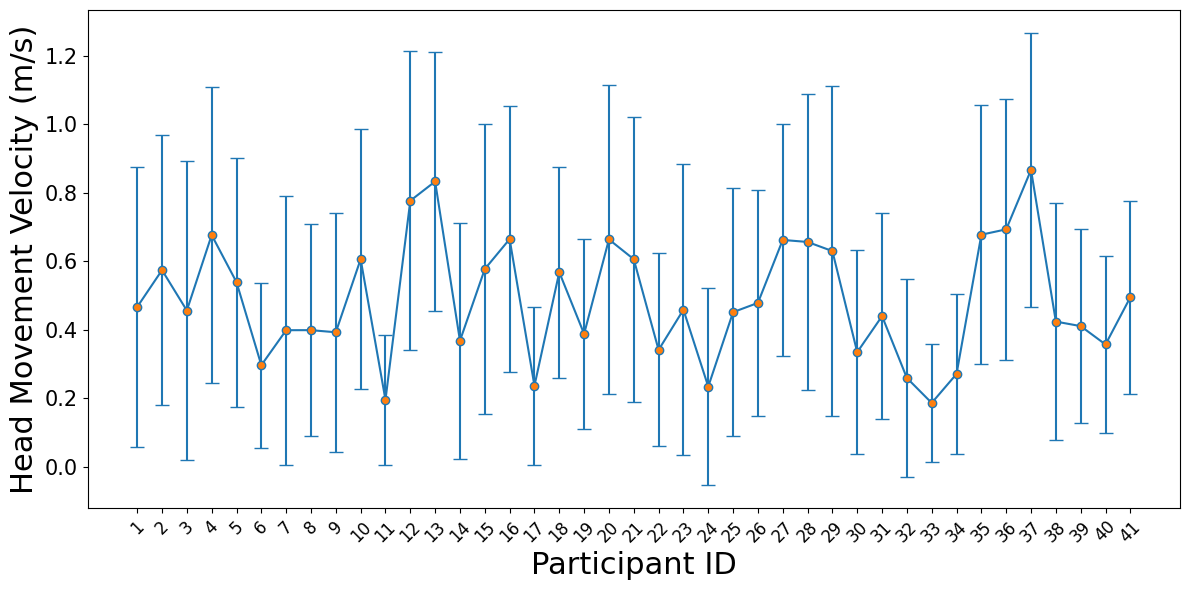

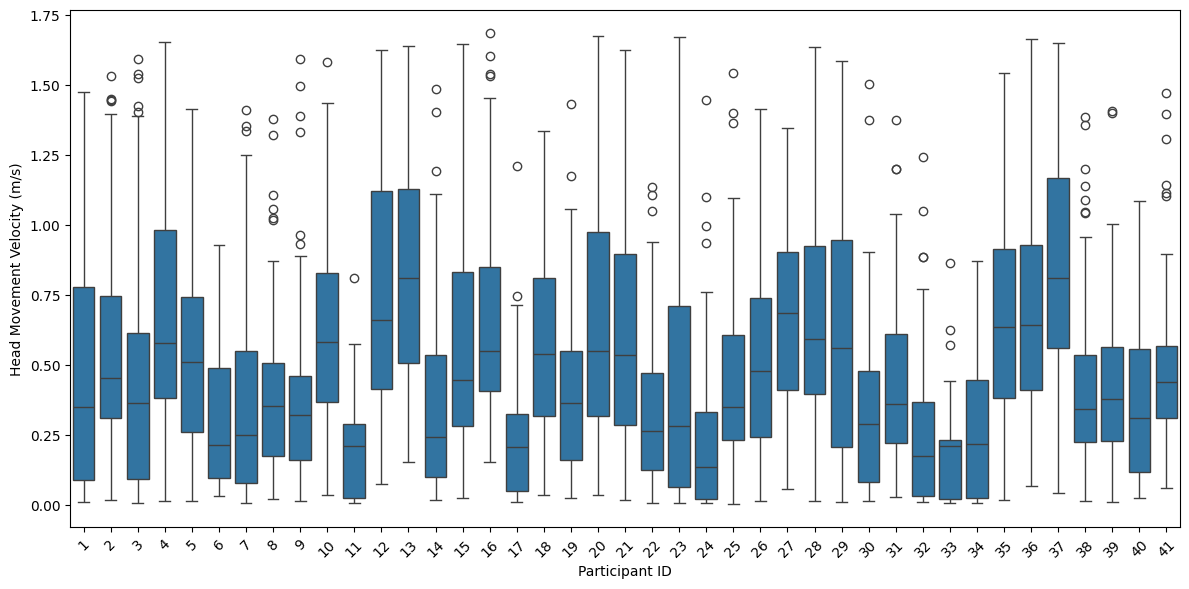

Head movement statistics:
Overall mean: 0.4784 ± 0.3852 m/s
Median: 0.4052 m/s


In [8]:
# Plot head movement per second - Average with error bars
plt.figure(figsize=(12, 6))
participant_head_stats = (
    velocity_df.groupby('participant_id')['head_velocity_m_per_s']
    .agg(['mean', 'std'])
    .reset_index()
)
plt.errorbar(
    range(len(participant_head_stats)),
    participant_head_stats['mean'],
    yerr=participant_head_stats['std'],
    fmt='o-',
    capsize=5,
    alpha=1.0,
    color='tab:blue',
    markerfacecolor='tab:orange',
)
plt.xlabel('Participant ID', fontsize='22')
plt.ylabel('Head Movement Velocity (m/s)', fontsize='22')
##plt.title('Average Head Movement Velocity per Participant (with std dev)')
plt.xticks(
    range(len(participant_head_stats)),
    participant_head_stats['participant_id'],
    rotation=45,
    fontsize=12,
)
# plt.ylim(0, 2.5)  # Set y-axis limits
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_movement_average.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(results_dir, 'head_movement_average.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot head movement per second - Distribution box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='participant_id', y='head_velocity_m_per_s')
plt.xlabel('Participant ID')
plt.ylabel('Head Movement Velocity (m/s)')
# plt.title('Distribution of Head Movement Velocities per Participant')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'head_movement_distribution.pdf'), dpi=300, bbox_inches='tight'
)
plt.savefig(
    os.path.join(results_dir, 'head_movement_distribution.png'), dpi=300, bbox_inches='tight'
)
plt.show()

print(f'Head movement statistics:')
print(
    f'Overall mean: {velocity_df["head_velocity_m_per_s"].mean():.4f} ± {velocity_df["head_velocity_m_per_s"].std():.4f} m/s'
)
print(f'Median: {velocity_df["head_velocity_m_per_s"].median():.4f} m/s')

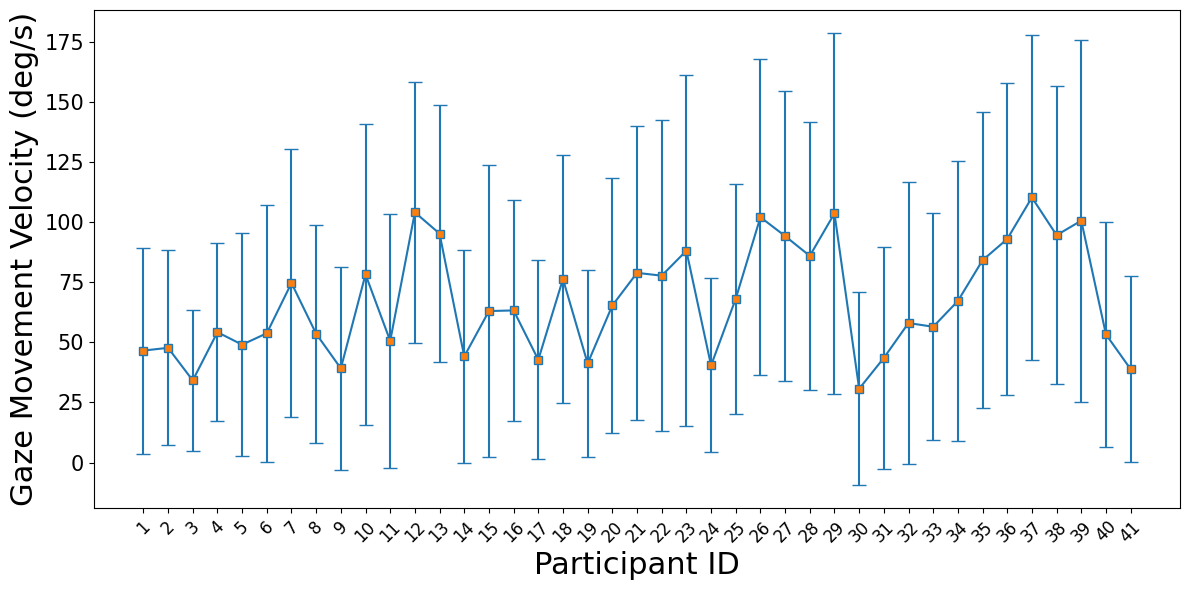

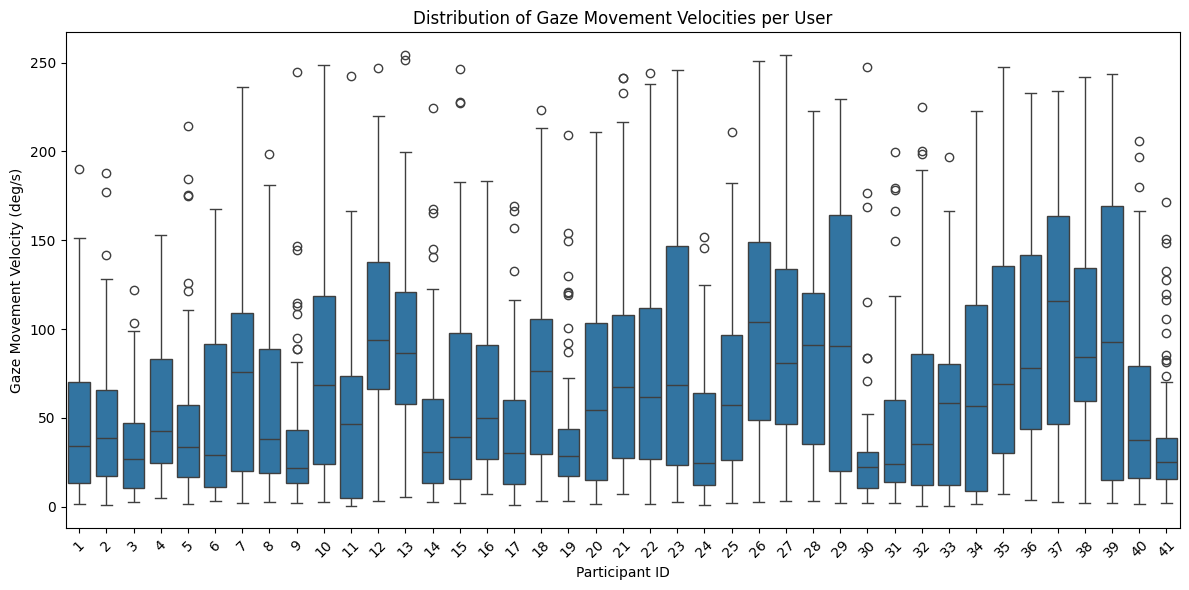

Gaze movement statistics:
Overall mean: 65.7282 ± 57.3814 deg/s
Median: 49.7990 deg/s


In [9]:
# Plot gaze movement per second - Average with error bars
plt.figure(figsize=(12, 6))
user_gaze_stats = (
    velocity_df.groupby('participant_id')['gaze_velocity_deg_per_s']
    .agg(['mean', 'std'])
    .reset_index()
)
plt.errorbar(
    range(len(user_gaze_stats)),
    user_gaze_stats['mean'],
    yerr=user_gaze_stats['std'],
    fmt='s-',
    capsize=5,
    alpha=1.0,
    color='tab:blue',
    markerfacecolor='tab:orange',
)
plt.xlabel('Participant ID', fontsize='22')
plt.ylabel('Gaze Movement Velocity (deg/s)', fontsize='22')
# plt.title('Average Gaze Movement Velocity per User (with std dev)')
plt.xticks(range(len(user_gaze_stats)), user_gaze_stats['participant_id'], rotation=45, fontsize=12)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'gaze_movement_average.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(results_dir, 'gaze_movement_average.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot gaze movement per second - Distribution box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='participant_id', y='gaze_velocity_deg_per_s')
plt.xlabel('Participant ID')
plt.ylabel('Gaze Movement Velocity (deg/s)')
plt.title('Distribution of Gaze Movement Velocities per User')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_distribution.pdf'), dpi=300, bbox_inches='tight'
)
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_distribution.png'), dpi=300, bbox_inches='tight'
)
plt.show()

print(f'Gaze movement statistics:')
print(
    f'Overall mean: {velocity_df["gaze_velocity_deg_per_s"].mean():.4f} ± {velocity_df["gaze_velocity_deg_per_s"].std():.4f} deg/s'
)
print(f'Median: {velocity_df["gaze_velocity_deg_per_s"].median():.4f} deg/s')

In [10]:
def classify_participants_by_movement(velocity_df):
    """
    Classify participants into low, medium, high movement categories based on percentiles.
    """
    # Calculate average velocities per participant
    participant_stats = (
        velocity_df.groupby('participant_id')
        .agg({'head_velocity_m_per_s': 'mean', 'gaze_velocity_deg_per_s': 'mean'})
        .reset_index()
    )

    # Calculate percentiles for head movement
    head_25th = np.percentile(participant_stats['head_velocity_m_per_s'], 25)
    head_75th = np.percentile(participant_stats['head_velocity_m_per_s'], 75)

    # Calculate percentiles for gaze movement
    gaze_25th = np.percentile(participant_stats['gaze_velocity_deg_per_s'], 25)
    gaze_75th = np.percentile(participant_stats['gaze_velocity_deg_per_s'], 75)

    # Classify based on head movement
    def classify_head_movement(vel):
        if vel <= head_25th:
            return 'Low'
        elif vel >= head_75th:
            return 'High'
        else:
            return 'Medium'

    # Classify based on gaze movement
    def classify_gaze_movement(vel):
        if vel <= gaze_25th:
            return 'Low'
        elif vel >= gaze_75th:
            return 'High'
        else:
            return 'Medium'

    participant_stats['head_movement_category'] = participant_stats['head_velocity_m_per_s'].apply(
        classify_head_movement
    )
    participant_stats['gaze_movement_category'] = participant_stats[
        'gaze_velocity_deg_per_s'
    ].apply(classify_gaze_movement)

    # Create combined category (using head movement as primary)
    participant_stats['overall_movement_category'] = participant_stats['head_movement_category']

    print(f'Head movement thresholds: Low ≤ {head_25th:.4f}, High ≥ {head_75th:.4f} m/s')
    print(f'Gaze movement thresholds: Low ≤ {gaze_25th:.4f}, High ≥ {gaze_75th:.4f} deg/s')

    print('\nParticipant classification by head movement:')
    print(participant_stats['head_movement_category'].value_counts())

    print('\nParticipant classification by gaze movement:')
    print(participant_stats['gaze_movement_category'].value_counts())

    # Analyze category overlap
    print('\nCategory overlap analysis:')
    overlap_analysis = (
        participant_stats.groupby(['head_movement_category', 'gaze_movement_category'])
        .size()
        .reset_index(name='count')
    )
    print(overlap_analysis)

    # Check if same participants are in same categories
    same_category_participants = participant_stats[
        participant_stats['head_movement_category'] == participant_stats['gaze_movement_category']
    ]
    print(
        f'\nParticipants with same head and gaze movement categories: {len(same_category_participants)} out of {len(participant_stats)} ({len(same_category_participants) / len(participant_stats) * 100:.1f}%)'
    )

    for category in CATEGORY_ORDER:
        head_participants = set(
            participant_stats[participant_stats['head_movement_category'] == category][
                'participant_id'
            ]
        )
        gaze_participants = set(
            participant_stats[participant_stats['gaze_movement_category'] == category][
                'participant_id'
            ]
        )
        overlap = head_participants.intersection(gaze_participants)
        print(
            f'{category} movement - Overlap: {len(overlap)}/{len(head_participants)} head participants are also {category} gaze participants ({len(overlap) / len(head_participants) * 100:.1f}%)'
        )

    return participant_stats


# Classify participants
participant_classifications = classify_participants_by_movement(velocity_df)
participant_classifications.head(10)

Head movement thresholds: Low ≤ 0.3680, High ≥ 0.6298 m/s
Gaze movement thresholds: Low ≤ 47.6822, High ≥ 85.9134 deg/s

Participant classification by head movement:
head_movement_category
Medium    19
High      11
Low       11
Name: count, dtype: int64

Participant classification by gaze movement:
gaze_movement_category
Medium    19
Low       11
High      11
Name: count, dtype: int64

Category overlap analysis:
  head_movement_category gaze_movement_category  count
0                   High                   High      7
1                   High                 Medium      4
2                    Low                    Low      4
3                    Low                 Medium      7
4                 Medium                   High      4
5                 Medium                    Low      7
6                 Medium                 Medium      8

Participants with same head and gaze movement categories: 19 out of 41 (46.3%)
Low movement - Overlap: 4/11 head participants are also Low gaze

participant_id  head_velocity_m_per_s  gaze_velocity_deg_per_s  \
0               1               0.466574                46.549841   
1               2               0.574190                47.682156   
2               3               0.456322                34.135747   
3               4               0.676541                54.188796   
4               5               0.539102                48.996915   
5               6               0.296695                53.739486   
6               7               0.398821                74.626036   
7               8               0.398955                53.530409   
8               9               0.392787                39.135773   
9              10               0.606039                78.211624   

  head_movement_category gaze_movement_category overall_movement_category  
0                 Medium                    Low                    Medium  
1                 Medium                    Low                    Medium  
2                 Medium                    Low                    Medium  
3                   High                 Medium                      High  
4                 Medium                 Medium                    Medium  
5                    Low                 Medium                       Low  
6                 Medium                 Medium                    Medium  
7                 Medium                 Medium                    Medium  
8                 Medium                    Low                    Medium  
9                 Medium                 Medium                    Medium

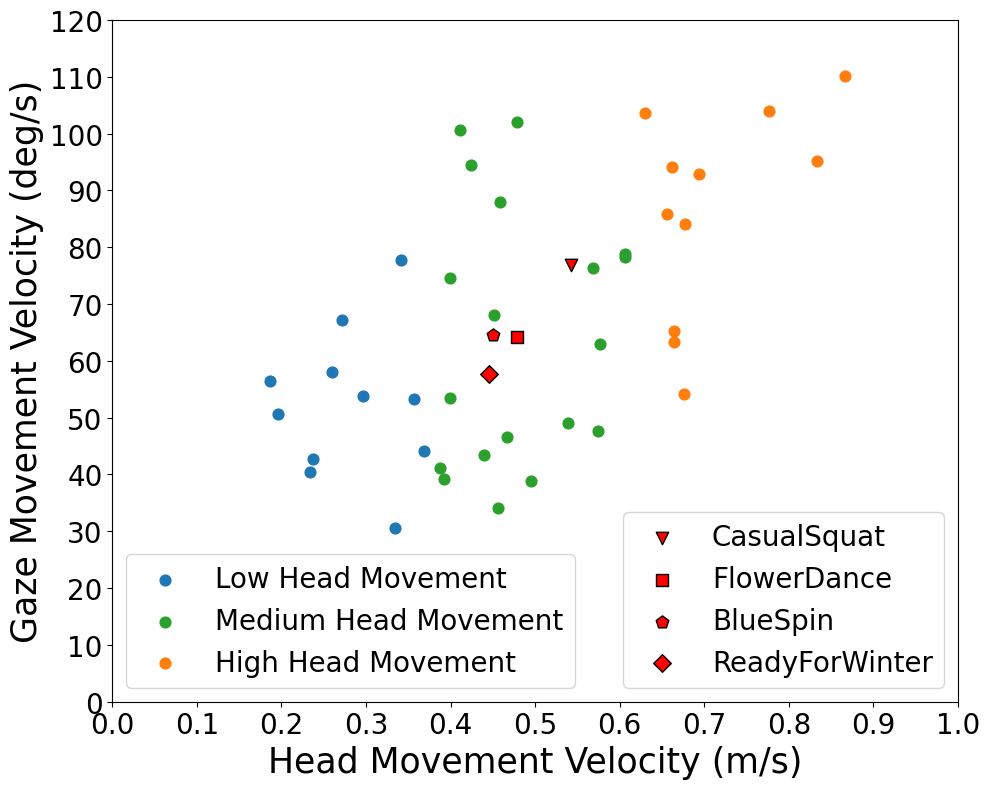

Average velocities by movement category:
Low Movement - Head: 0.2801 m/s, Gaze: 52.2 deg/s
Medium Movement - Head: 0.4806 m/s, Gaze: 64.1 deg/s
High Movement - Head: 0.7092 m/s, Gaze: 86.6 deg/s


In [ ]:
# Scatter plot of head vs gaze velocities with categories
scatter_plot_ax = plt.figure(figsize=(10, 8))
movement_category_plots = []
for category in CATEGORY_ORDER:
    subset = participant_classifications[participant_classifications['head_movement_category'] == category]
    ax = plt.scatter(
        subset['head_velocity_m_per_s'],
        subset['gaze_velocity_deg_per_s'],
        c=CATEGORY_COLORS[category],
        label=f'{category} Head Movement',
        alpha=1.0,
        s=60,
    )
    movement_category_plots.append(ax)

# Point clouds ranked by head movement (highest to lowest):
# 1. PCCasualSquat: 0.5421 m/s
# 2. PCFlowerDance: 0.4784 m/s
# 3. PCBlueSpin: 0.4504 m/s
# 4. PCReadyForWinter: 0.4450 m/s

# Point clouds ranked by gaze movement (highest to lowest):
# 1. PCCasualSquat: 76.9 deg/s
# 3. PCFlowerDance: 64.2 deg/s
# 2. PCBlueSpin: 64.5 deg/s
# 4. PCReadyForWinter: 57.6 deg/s


casualSquatAx = plt.scatter([0.5421],[76.9],marker='v',color='red',alpha=1.0,s=80,label='CasualSquat',edgecolors='black')
flowerDanceAx = plt.scatter([0.4784],[64.2],marker='s',color='red',alpha=1.0,s=80,label='FlowerDance',edgecolors='black')
blueSpinAx = plt.scatter([0.4504],[64.5],marker='p',color='red',alpha=1.0,s=90,label='BlueSpin',edgecolors='black')
readyForWinterAx = plt.scatter([0.4450],[57.6],marker='D',color='red',alpha=1.0,s=80,label='ReadyForWinter',edgecolors='black')
pointCloudPlots = [casualSquatAx, flowerDanceAx, blueSpinAx, readyForWinterAx]

plt.xlabel('Head Movement Velocity (m/s)', fontsize=25)
plt.ylabel('Gaze Movement Velocity (deg/s)', fontsize=25)

plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=20)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], fontsize=20)

first_legend = plt.legend(fontsize=17, loc='lower left', ncols=1, handles=movement_category_plots)
plt.legend(fontsize=17, loc='lower right', ncols=1, handles=pointCloudPlots)

# we need to add the first legend back to the graph otherwise it wont show
scatter_plot_ax.add_artist(first_legend)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_vs_gaze_scatter.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(results_dir, 'head_vs_gaze_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate average velocities by category for printing
category_stats = (
    participant_classifications.groupby('head_movement_category')
    .agg({'head_velocity_m_per_s': 'mean', 'gaze_velocity_deg_per_s': 'mean'})
    .reset_index()
)

# Print average velocities
print('Average velocities by movement category:')
for category in CATEGORY_ORDER:
    if category in category_stats['head_movement_category'].values:
        head_vel = category_stats[category_stats['head_movement_category'] == category][
            'head_velocity_m_per_s'
        ].iloc[0]
        gaze_vel = category_stats[category_stats['head_movement_category'] == category][
            'gaze_velocity_deg_per_s'
        ].iloc[0]
        print(f'{category} Movement - Head: {head_vel:.4f} m/s, Gaze: {gaze_vel:.1f} deg/s')



In [12]:
# Merge classifications back to velocity data
velocity_with_categories = velocity_df.merge(
    participant_classifications[
        [
            'participant_id',
            'head_movement_category',
            'gaze_movement_category',
            'overall_movement_category',
        ]
    ],
    on='participant_id',
)

Head Movement By Category Over Time


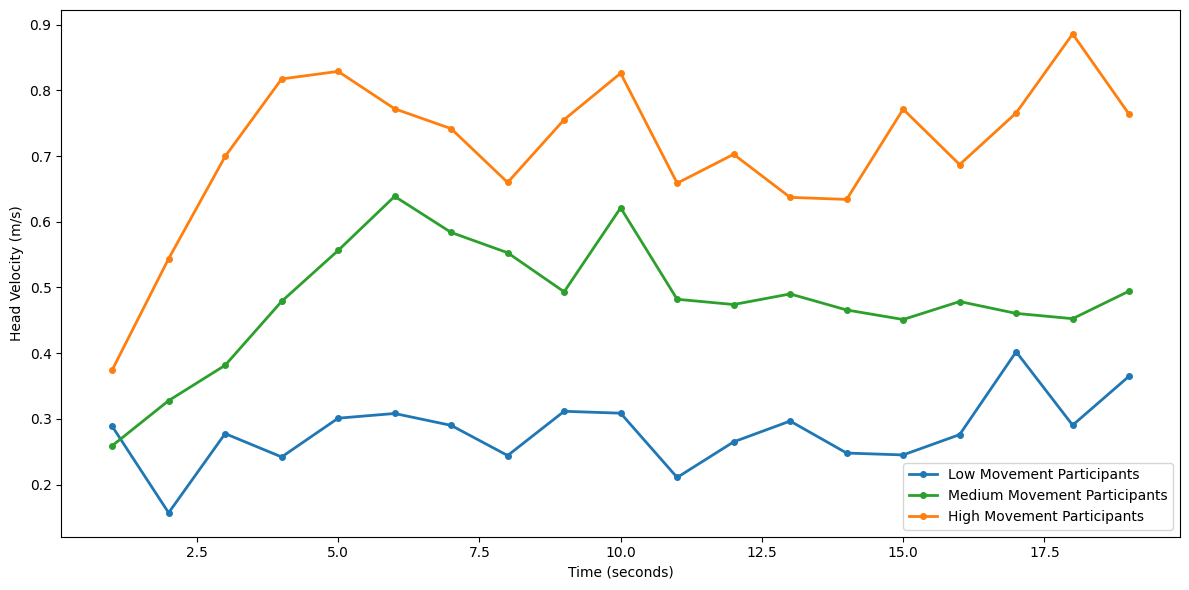

/tmp/ipykernel_11247/3347783571.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


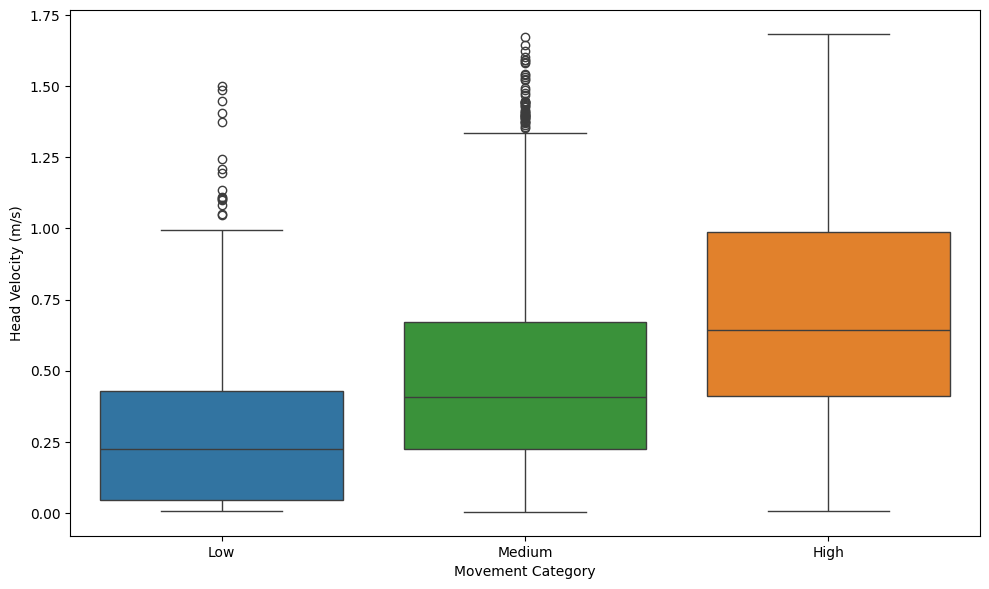

In [13]:
print('Head Movement By Category Over Time')

# Head movement by category over time
plt.figure(figsize=(12, 6))
category_time_head = (
    velocity_with_categories.groupby(['overall_movement_category', 'second'])[
        'head_velocity_m_per_s'
    ]
    .mean()
    .reset_index()
)
for category in CATEGORY_ORDER:
    subset = category_time_head[category_time_head['overall_movement_category'] == category]
    plt.plot(
        subset['second'],
        subset['head_velocity_m_per_s'],
        label=f'{category} Movement Participants',
        linewidth=2,
        marker='o',
        markersize=4,
        color=CATEGORY_COLORS[category],
        alpha=1.0,
    )

plt.xlabel('Time (seconds)')
plt.ylabel('Head Velocity (m/s)')
# plt.title('Head Movement Over Time by Category')
plt.legend()
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'head_movement_over_time_by_category.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'head_movement_over_time_by_category.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Head velocity distribution by category - Box plots
plt.figure(figsize=(10, 6))
# Ensure proper ordering
velocity_with_categories['overall_movement_category'] = pd.Categorical(
    velocity_with_categories['overall_movement_category'], categories=CATEGORY_ORDER, ordered=True
)
sns.boxplot(
    data=velocity_with_categories,
    x='overall_movement_category',
    y='head_velocity_m_per_s',
    palette=[CATEGORY_COLORS[cat] for cat in CATEGORY_ORDER],
)
plt.xlabel('Movement Category')
plt.ylabel('Head Velocity (m/s)')
# plt.title('Head Velocity Distribution by Category')
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'head_velocity_distribution_by_category.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'head_velocity_distribution_by_category.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()



Gaze Movement By Category Over Time


/tmp/ipykernel_11247/231249127.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  velocity_with_categories.groupby(['overall_movement_category', 'second'])[


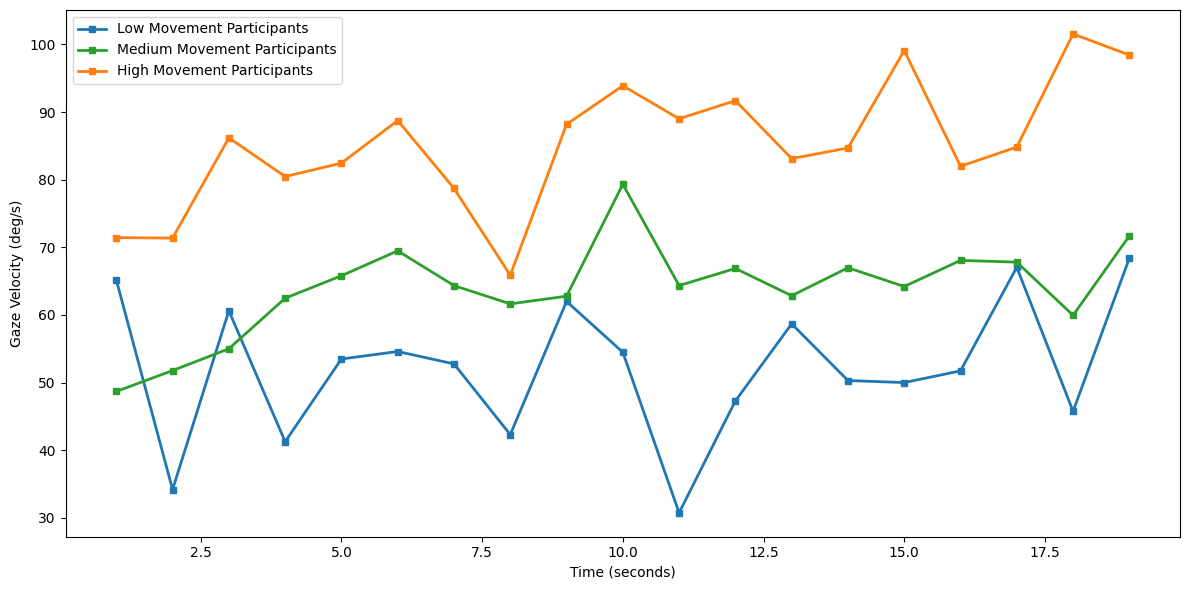

/tmp/ipykernel_11247/231249127.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


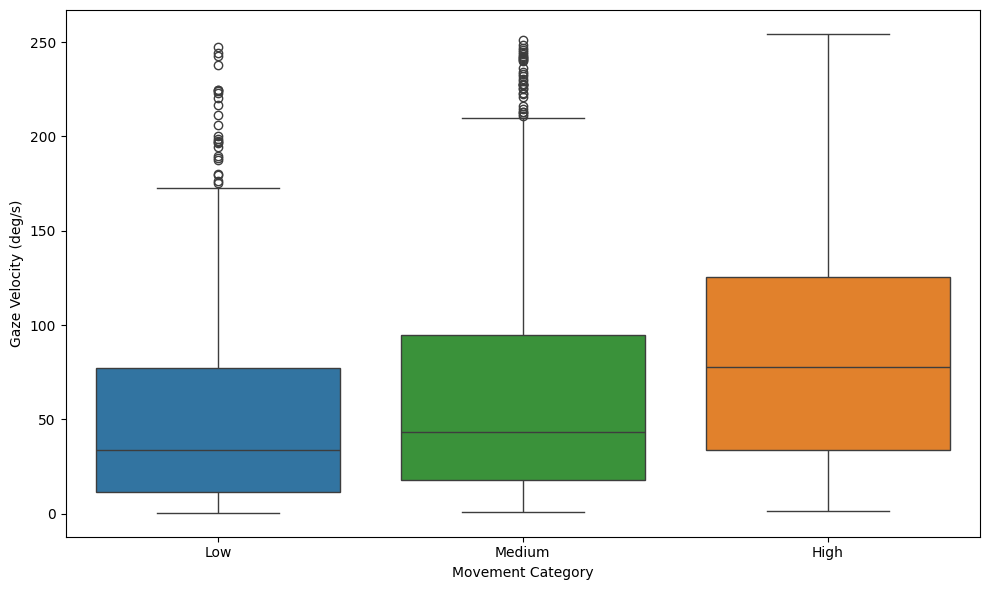

In [14]:
print('Gaze Movement By Category Over Time')

# Gaze movement by category over time
plt.figure(figsize=(12, 6))
category_time_gaze = (
    velocity_with_categories.groupby(['overall_movement_category', 'second'])[
        'gaze_velocity_deg_per_s'
    ]
    .mean()
    .reset_index()
)
for category in CATEGORY_ORDER:
    subset = category_time_gaze[category_time_gaze['overall_movement_category'] == category]
    plt.plot(
        subset['second'],
        subset['gaze_velocity_deg_per_s'],
        label=f'{category} Movement Participants',
        linewidth=2,
        marker='s',
        markersize=4,
        color=CATEGORY_COLORS[category],
        alpha=1.0,
    )

plt.xlabel('Time (seconds)')
plt.ylabel('Gaze Velocity (deg/s)')
# plt.title('Gaze Movement Over Time by Category')
plt.legend()
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_over_time_by_category.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_over_time_by_category.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Gaze velocity distribution by category - Box plots
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=velocity_with_categories,
    x='overall_movement_category',
    y='gaze_velocity_deg_per_s',
    palette=[CATEGORY_COLORS[cat] for cat in CATEGORY_ORDER],
)
plt.xlabel('Movement Category')
plt.ylabel('Gaze Velocity (deg/s)')
# plt.title('Gaze Velocity Distribution by Category')
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'gaze_velocity_distribution_by_category.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'gaze_velocity_distribution_by_category.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

Analyzing movement patterns over time by Point Cloud...


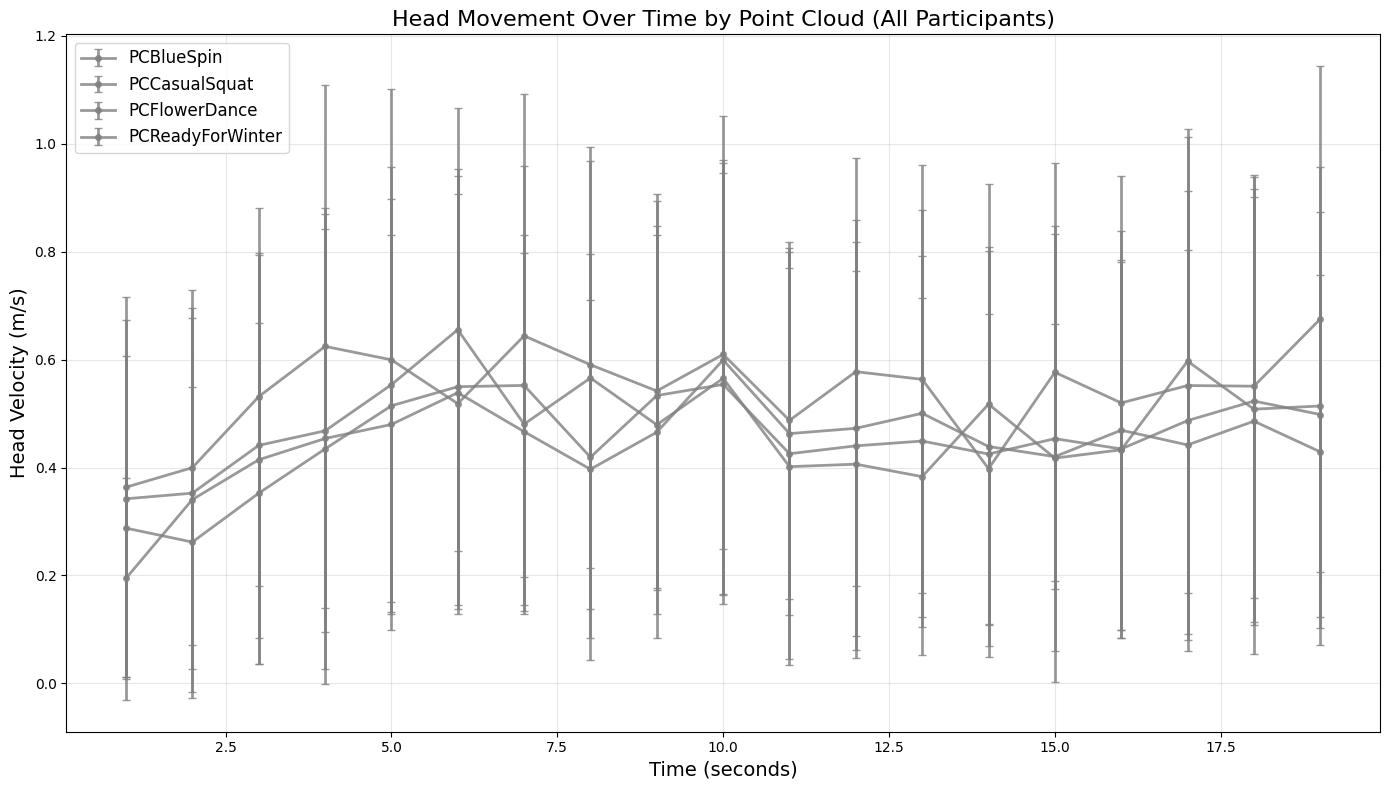

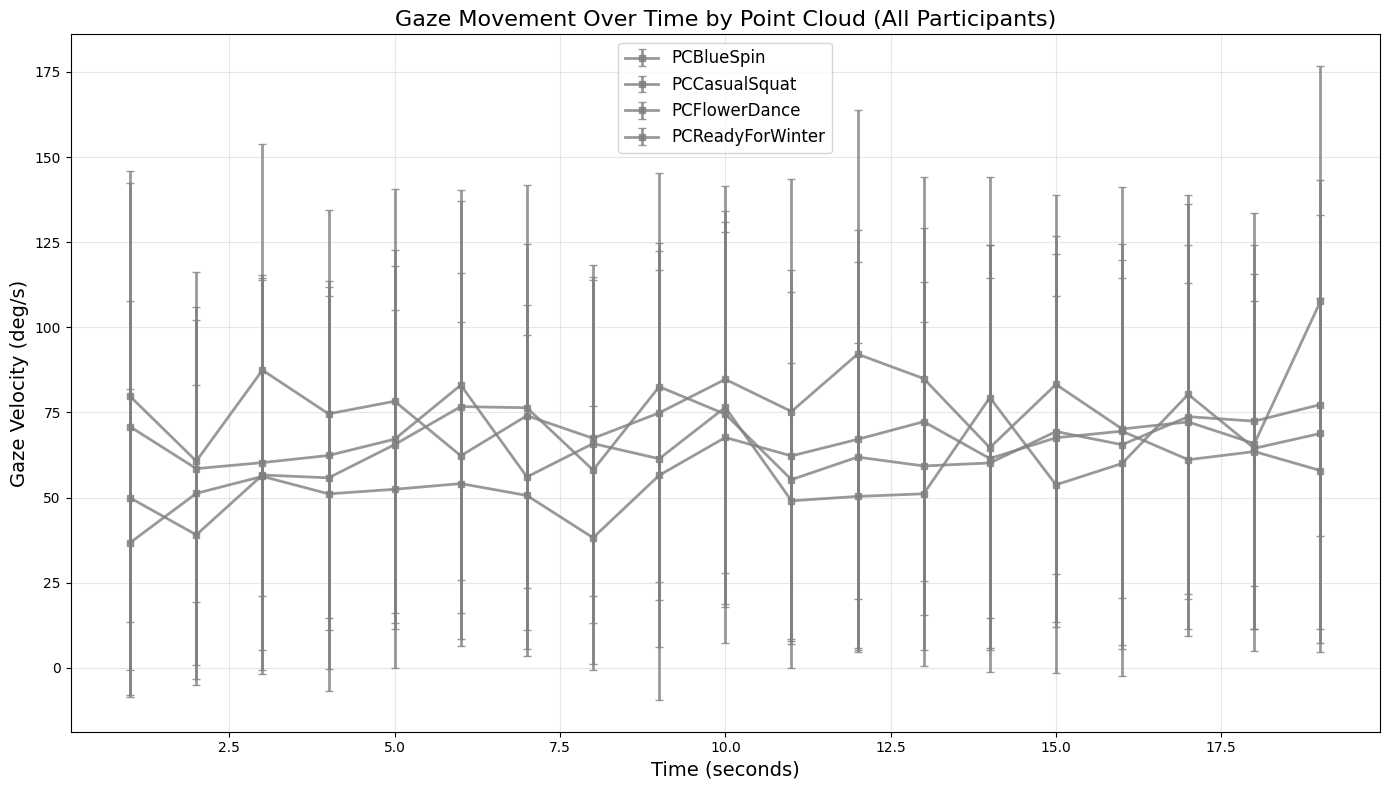

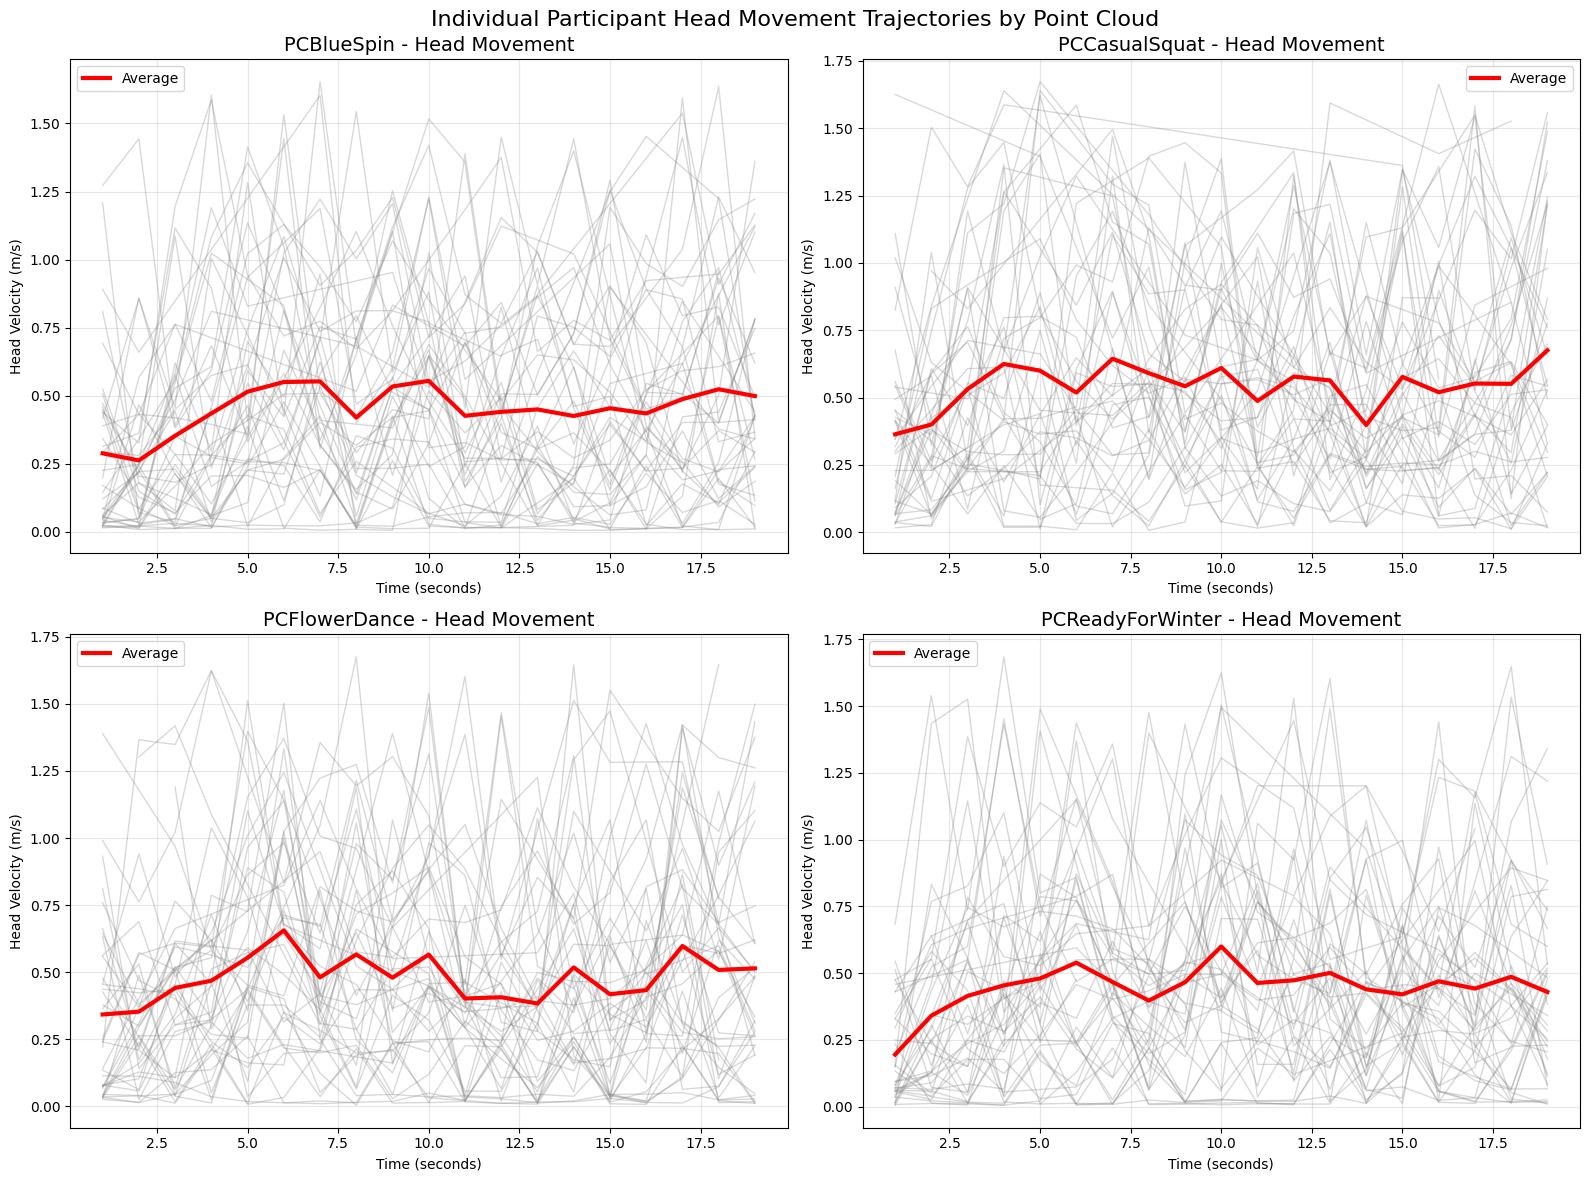

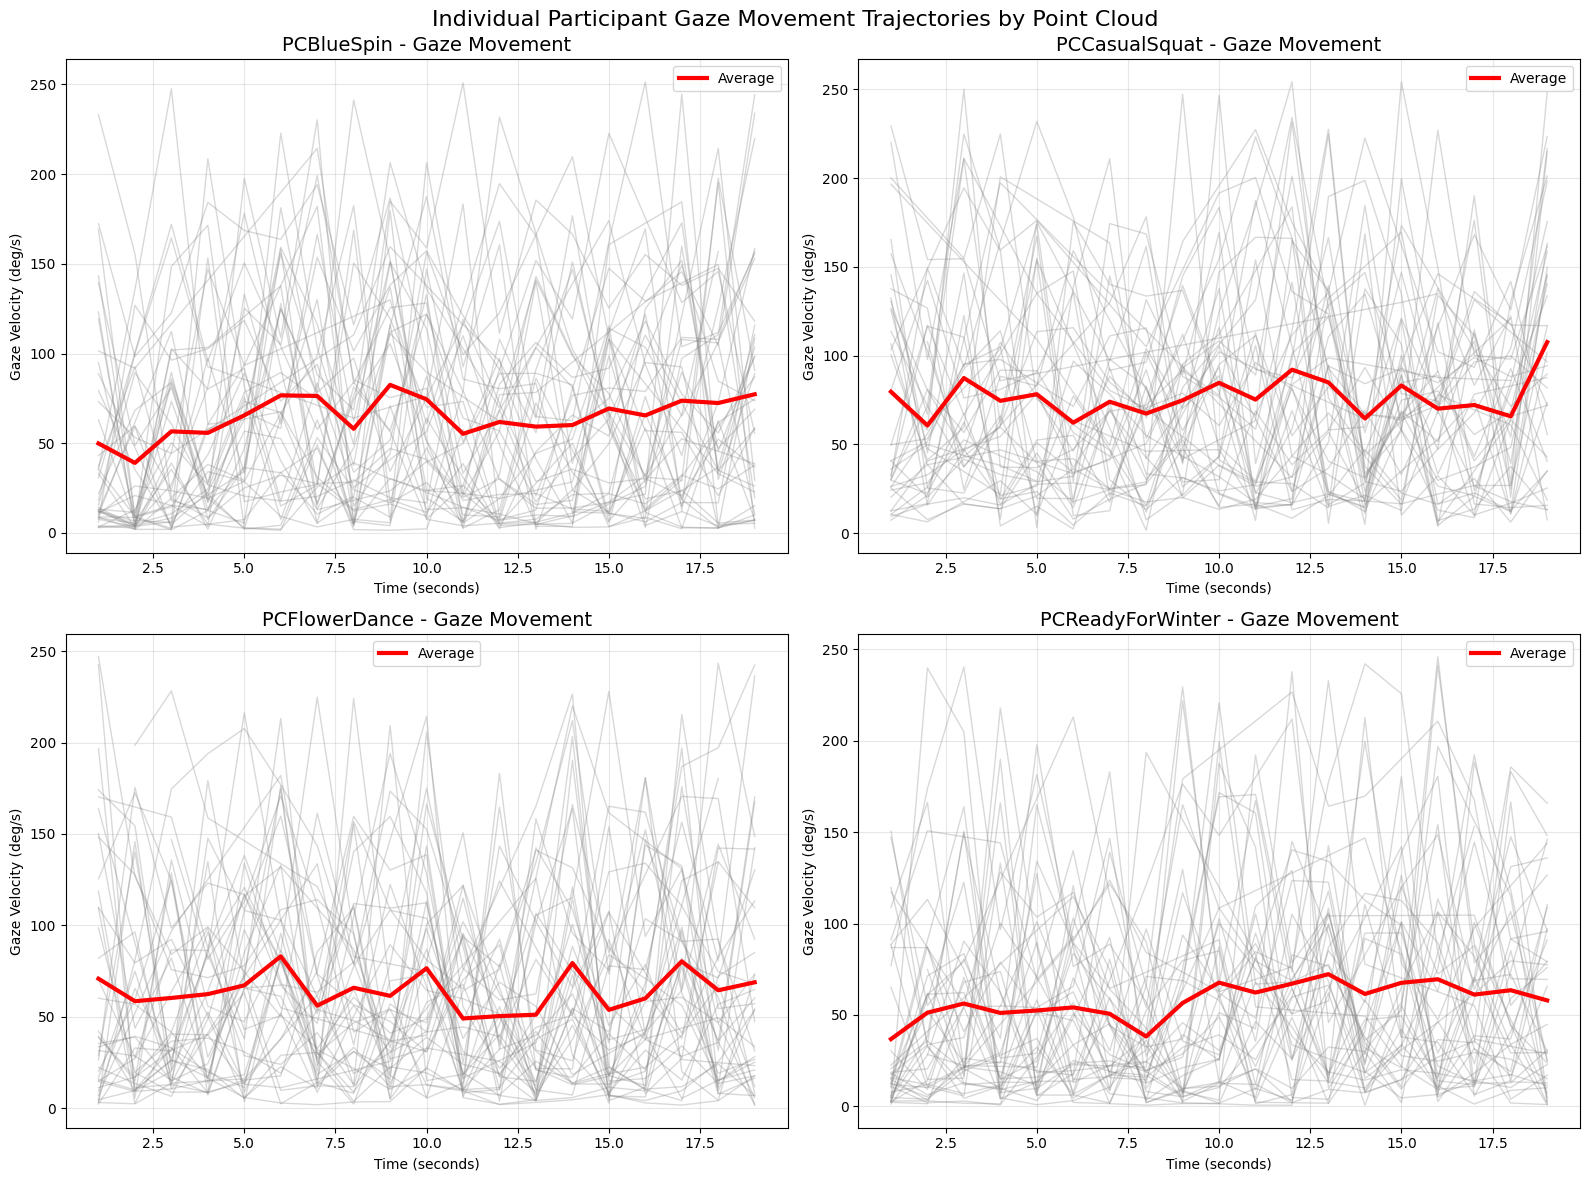

TEMPORAL MOVEMENT ANALYSIS BY POINT CLOUD:

PCBLUESPIN:
  Duration: 19.0 seconds
  Head Movement by Period:
    Early (0-6.3s): 0.3934 ± 0.3709 m/s
    Middle (6.3-12.7s): 0.4876 ± 0.3829 m/s
    Late (12.7-19.0s): 0.4677 ± 0.3814 m/s
  Gaze Movement by Period:
    Early (0-6.3s): 56.6 ± 55.4 deg/s
    Middle (6.3-12.7s): 68.1 ± 59.4 deg/s
    Late (12.7-19.0s): 68.4 ± 59.0 deg/s

PCCASUALSQUAT:
  Duration: 19.0 seconds
  Head Movement by Period:
    Early (0-6.3s): 0.5020 ± 0.4122 m/s
    Middle (6.3-12.7s): 0.5753 ± 0.3794 m/s
    Late (12.7-19.0s): 0.5475 ± 0.4072 m/s
  Gaze Movement by Period:
    Early (0-6.3s): 74.0 ± 59.0 deg/s
    Middle (6.3-12.7s): 78.1 ± 58.1 deg/s
    Late (12.7-19.0s): 78.4 ± 57.0 deg/s

PCFLOWERDANCE:
  Duration: 19.0 seconds
  Head Movement by Period:
    Early (0-6.3s): 0.4686 ± 0.3801 m/s
    Middle (6.3-12.7s): 0.4836 ± 0.3793 m/s
    Late (12.7-19.0s): 0.4823 ± 0.3992 m/s
  Gaze Movement by Period:
    Early (0-6.3s): 67.0 ± 58.3 deg/s
    Middle (6.

In [15]:
# Movement over time analysis by Point Cloud
print('Analyzing movement patterns over time by Point Cloud...')

# Calculate time-series data by point cloud
pc_time_head = (
    velocity_with_categories.groupby(['pc_name', 'second'])['head_velocity_m_per_s']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
pc_time_gaze = (
    velocity_with_categories.groupby(['pc_name', 'second'])['gaze_velocity_deg_per_s']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# Create a color palette for point clouds
pc_colors = {
    'BlueSpin': '#1f77b4',
    'CasualSquat': '#ff7f0e',
    'FlowerDance': '#2ca02c',
    'ReadyForWinter': '#d62728',
}

# Head movement over time by point cloud - Line plot with error bars
plt.figure(figsize=(14, 8))
for pc_name in velocity_df['pc_name'].unique():
    subset = pc_time_head[pc_time_head['pc_name'] == pc_name]
    plt.errorbar(
        subset['second'],
        subset['mean'],
        yerr=subset['std'],
        label=f'{pc_name}',
        linewidth=2,
        marker='o',
        markersize=4,
        color=pc_colors.get(pc_name, 'gray'),
        alpha=0.8,
        capsize=3,
    )

plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Head Velocity (m/s)', fontsize=14)
plt.title('Head Movement Over Time by Point Cloud (All Participants)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'head_movement_over_time_by_pointcloud.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'head_movement_over_time_by_pointcloud.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Gaze movement over time by point cloud - Line plot with error bars
plt.figure(figsize=(14, 8))
for pc_name in velocity_df['pc_name'].unique():
    subset = pc_time_gaze[pc_time_gaze['pc_name'] == pc_name]
    plt.errorbar(
        subset['second'],
        subset['mean'],
        yerr=subset['std'],
        label=f'{pc_name}',
        linewidth=2,
        marker='s',
        markersize=4,
        color=pc_colors.get(pc_name, 'gray'),
        alpha=0.8,
        capsize=3,
    )

plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Gaze Velocity (deg/s)', fontsize=14)
plt.title('Gaze Movement Over Time by Point Cloud (All Participants)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_over_time_by_pointcloud.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_over_time_by_pointcloud.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Individual participant trajectories by point cloud - Head movement
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, pc_name in enumerate(sorted(velocity_df['pc_name'].unique())):
    pc_data = velocity_with_categories[velocity_with_categories['pc_name'] == pc_name]

    # Plot individual participant trajectories
    for participant_id in pc_data['participant_id'].unique():
        participant_data = pc_data[pc_data['participant_id'] == participant_id]
        axes[i].plot(
            participant_data['second'],
            participant_data['head_velocity_m_per_s'],
            alpha=0.3,
            linewidth=1,
            color='gray',
        )

    # Plot average trajectory
    avg_data = pc_data.groupby('second')['head_velocity_m_per_s'].mean().reset_index()
    axes[i].plot(
        avg_data['second'],
        avg_data['head_velocity_m_per_s'],
        linewidth=3,
        color=pc_colors.get(pc_name, 'red'),
        label='Average',
    )

    axes[i].set_title(f'{pc_name} - Head Movement', fontsize=14)
    axes[i].set_xlabel('Time (seconds)')
    axes[i].set_ylabel('Head Velocity (m/s)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Individual Participant Head Movement Trajectories by Point Cloud', fontsize=16)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'individual_head_trajectories_by_pointcloud.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'individual_head_trajectories_by_pointcloud.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Individual participant trajectories by point cloud - Gaze movement
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, pc_name in enumerate(sorted(velocity_df['pc_name'].unique())):
    pc_data = velocity_with_categories[velocity_with_categories['pc_name'] == pc_name]

    # Plot individual participant trajectories
    for participant_id in pc_data['participant_id'].unique():
        participant_data = pc_data[pc_data['participant_id'] == participant_id]
        axes[i].plot(
            participant_data['second'],
            participant_data['gaze_velocity_deg_per_s'],
            alpha=0.3,
            linewidth=1,
            color='gray',
        )

    # Plot average trajectory
    avg_data = pc_data.groupby('second')['gaze_velocity_deg_per_s'].mean().reset_index()
    axes[i].plot(
        avg_data['second'],
        avg_data['gaze_velocity_deg_per_s'],
        linewidth=3,
        color=pc_colors.get(pc_name, 'red'),
        label='Average',
    )

    axes[i].set_title(f'{pc_name} - Gaze Movement', fontsize=14)
    axes[i].set_xlabel('Time (seconds)')
    axes[i].set_ylabel('Gaze Velocity (deg/s)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Individual Participant Gaze Movement Trajectories by Point Cloud', fontsize=16)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'individual_gaze_trajectories_by_pointcloud.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'individual_gaze_trajectories_by_pointcloud.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Statistical analysis of temporal patterns
print('TEMPORAL MOVEMENT ANALYSIS BY POINT CLOUD:')
print('=' * 60)

for pc_name in sorted(velocity_df['pc_name'].unique()):
    pc_data = velocity_with_categories[velocity_with_categories['pc_name'] == pc_name]

    # Calculate statistics by time periods (early, middle, late)
    max_time = pc_data['second'].max()
    early_period = pc_data[pc_data['second'] <= max_time / 3]
    middle_period = pc_data[
        (pc_data['second'] > max_time / 3) & (pc_data['second'] <= 2 * max_time / 3)
    ]
    late_period = pc_data[pc_data['second'] > 2 * max_time / 3]

    print(f'\n{pc_name.upper()}:')
    print(f'  Duration: {max_time:.1f} seconds')
    print(f'  Head Movement by Period:')
    print(
        f'    Early (0-{max_time / 3:.1f}s): {early_period["head_velocity_m_per_s"].mean():.4f} ± {early_period["head_velocity_m_per_s"].std():.4f} m/s'
    )
    print(
        f'    Middle ({max_time / 3:.1f}-{2 * max_time / 3:.1f}s): {middle_period["head_velocity_m_per_s"].mean():.4f} ± {middle_period["head_velocity_m_per_s"].std():.4f} m/s'
    )
    print(
        f'    Late ({2 * max_time / 3:.1f}-{max_time:.1f}s): {late_period["head_velocity_m_per_s"].mean():.4f} ± {late_period["head_velocity_m_per_s"].std():.4f} m/s'
    )

    print(f'  Gaze Movement by Period:')
    print(
        f'    Early (0-{max_time / 3:.1f}s): {early_period["gaze_velocity_deg_per_s"].mean():.1f} ± {early_period["gaze_velocity_deg_per_s"].std():.1f} deg/s'
    )
    print(
        f'    Middle ({max_time / 3:.1f}-{2 * max_time / 3:.1f}s): {middle_period["gaze_velocity_deg_per_s"].mean():.1f} ± {middle_period["gaze_velocity_deg_per_s"].std():.1f} deg/s'
    )
    print(
        f'    Late ({2 * max_time / 3:.1f}-{max_time:.1f}s): {late_period["gaze_velocity_deg_per_s"].mean():.1f} ± {late_period["gaze_velocity_deg_per_s"].std():.1f} deg/s'
    )

print('=' * 60)

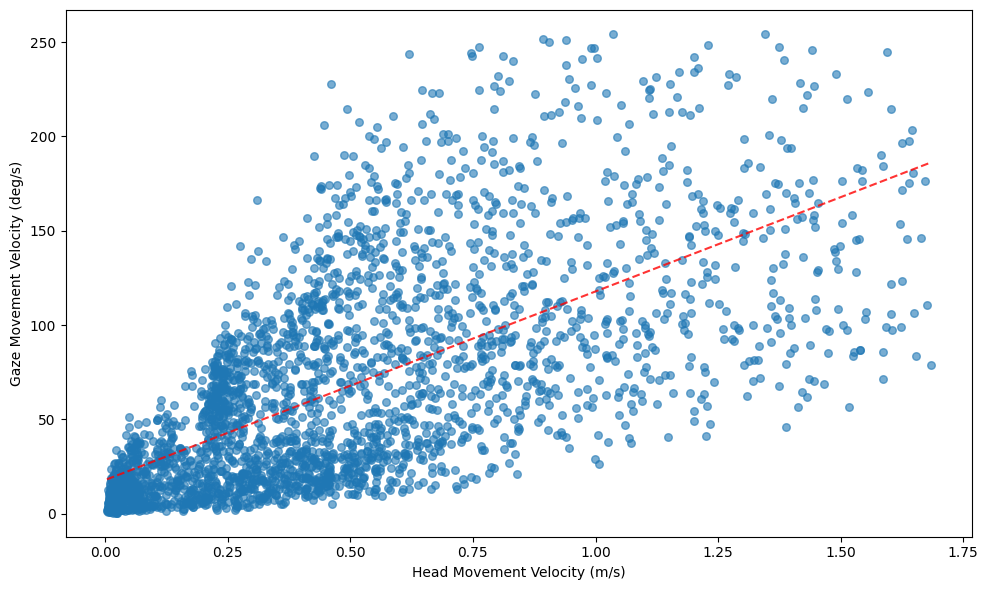

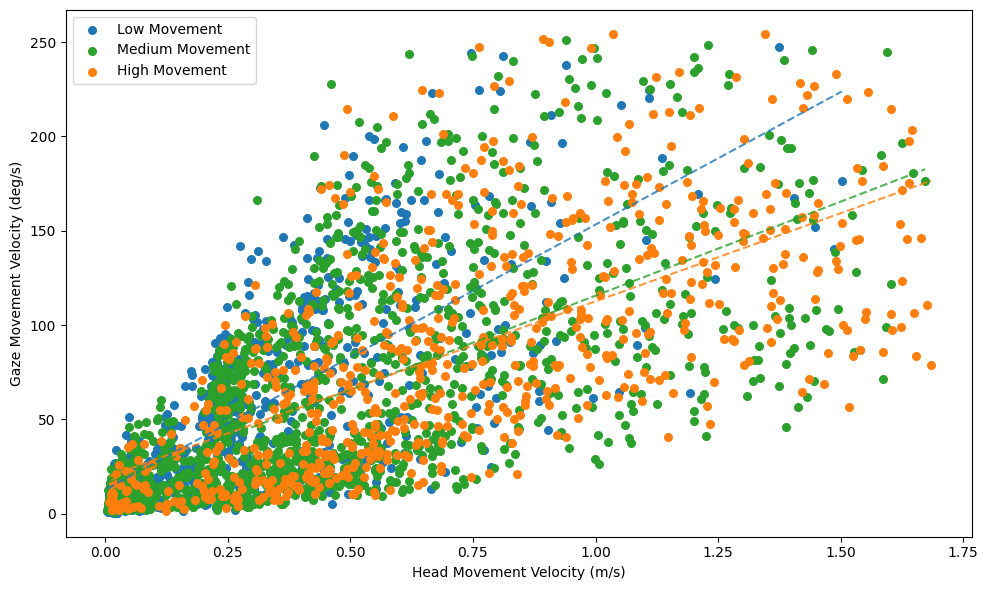

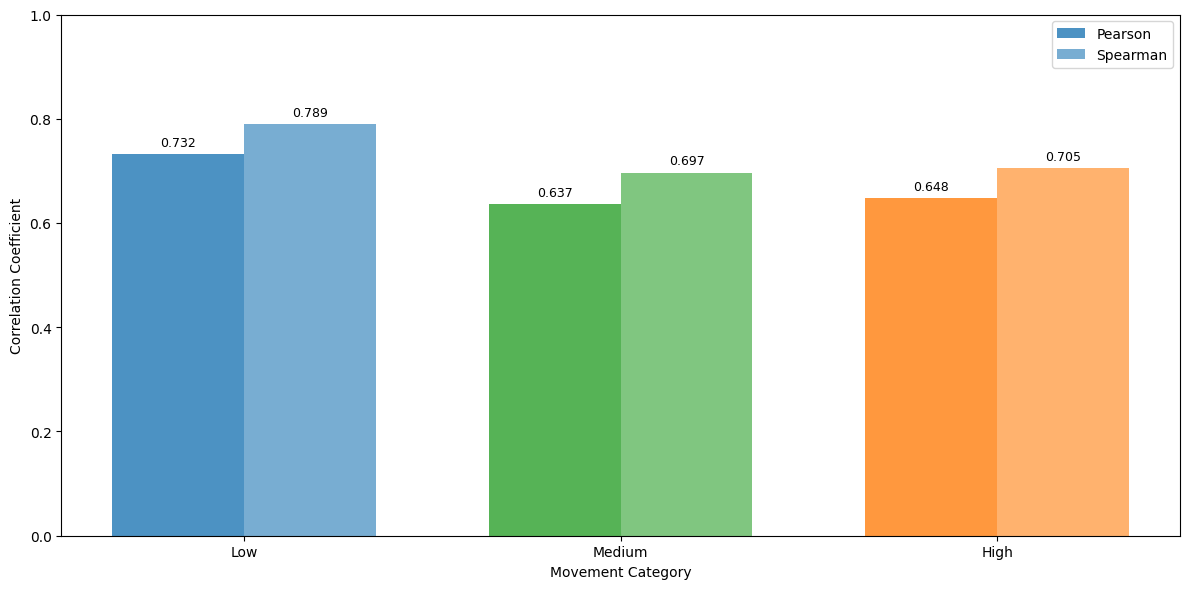

/tmp/ipykernel_11247/2985660915.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  velocity_with_categories.groupby('overall_movement_category')


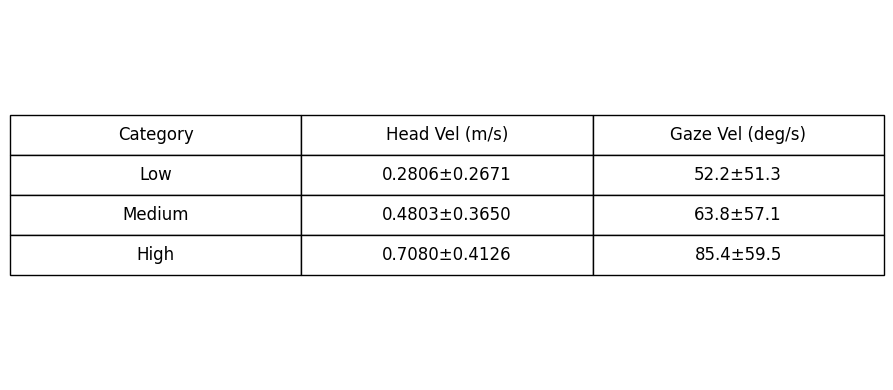

Correlation Analysis:
Overall Pearson correlation: 0.6708 (p=0.000000)
Overall Spearman correlation: 0.7361 (p=0.000000)

By category:
Low movement participants - Pearson: 0.7318, Spearman: 0.7894
Medium movement participants - Pearson: 0.6367, Spearman: 0.6966
High movement participants - Pearson: 0.6480, Spearman: 0.7054


In [16]:
# Head movement vs Gaze direction change analysis
from scipy.stats import pearsonr, spearmanr

# Overall correlation scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s'], alpha=0.6, s=30
)
# Add correlation line
z = np.polyfit(velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s'], 1)
p = np.poly1d(z)
plt.plot(
    velocity_df['head_velocity_m_per_s'].sort_values(),
    p(velocity_df['head_velocity_m_per_s'].sort_values()),
    'r--',
    alpha=0.8,
)

# Calculate both correlations
pearson_corr, pearson_p = pearsonr(
    velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s']
)
spearman_corr, spearman_p = spearmanr(
    velocity_df['head_velocity_m_per_s'], velocity_df['gaze_velocity_deg_per_s']
)

plt.xlabel('Head Movement Velocity (m/s)')
plt.ylabel('Gaze Movement Velocity (deg/s)')
# plt.title(f'Head vs Gaze Movement\n(Pearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f})')
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'head_vs_gaze_overall_correlation.pdf'), dpi=300, bbox_inches='tight'
)
plt.savefig(
    os.path.join(results_dir, 'head_vs_gaze_overall_correlation.png'), dpi=300, bbox_inches='tight'
)
plt.show()

# Head vs gaze by movement category
plt.figure(figsize=(10, 6))
for category in CATEGORY_ORDER:
    subset = velocity_with_categories[
        velocity_with_categories['overall_movement_category'] == category
    ]
    plt.scatter(
        subset['head_velocity_m_per_s'],
        subset['gaze_velocity_deg_per_s'],
        c=CATEGORY_COLORS[category],
        label=f'{category} Movement',
        alpha=1.0,
        s=30,
    )

    # Add correlation line for each category
    if len(subset) > 1:
        z = np.polyfit(subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s'], 1)
        p = np.poly1d(z)
        x_sorted = subset['head_velocity_m_per_s'].sort_values()
        plt.plot(x_sorted, p(x_sorted), color=CATEGORY_COLORS[category], linestyle='--', alpha=0.8)

plt.xlabel('Head Movement Velocity (m/s)')
plt.ylabel('Gaze Movement Velocity (deg/s)')
# plt.title('Head vs Gaze Movement by Category')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'head_vs_gaze_by_category.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(results_dir, 'head_vs_gaze_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Correlation analysis by category - Bar chart
plt.figure(figsize=(12, 6))
pearson_correlations = []
spearman_correlations = []
categories = []

for category in CATEGORY_ORDER:
    subset = velocity_with_categories[
        velocity_with_categories['overall_movement_category'] == category
    ]
    if len(subset) > 1:
        pearson_corr_cat, _ = pearsonr(
            subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s']
        )
        spearman_corr_cat, _ = spearmanr(
            subset['head_velocity_m_per_s'], subset['gaze_velocity_deg_per_s']
        )
        pearson_correlations.append(pearson_corr_cat)
        spearman_correlations.append(spearman_corr_cat)
        categories.append(category)

x = np.arange(len(categories))
width = 0.35

bars1 = plt.bar(
    x - width / 2,
    pearson_correlations,
    width,
    color=[CATEGORY_COLORS[cat] for cat in categories],
    alpha=0.8,
    label='Pearson',
)
bars2 = plt.bar(
    x + width / 2,
    spearman_correlations,
    width,
    color=[CATEGORY_COLORS[cat] for cat in categories],
    alpha=0.6,
    label='Spearman',
)

plt.ylabel('Correlation Coefficient')
plt.xlabel('Movement Category')
# plt.title('Head-Gaze Movement Correlation by Category (Pearson vs Spearman)')
plt.xticks(x, categories)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
for bar, corr in zip(bars1, pearson_correlations):
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 0.01,
        f'{corr:.3f}',
        ha='center',
        va='bottom',
        fontsize=9,
    )
for bar, corr in zip(bars2, spearman_correlations):
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 0.01,
        f'{corr:.3f}',
        ha='center',
        va='bottom',
        fontsize=9,
    )

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'correlation_by_category.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(results_dir, 'correlation_by_category.png'), dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics table
plt.figure(figsize=(10, 4))
summary_stats = (
    velocity_with_categories.groupby('overall_movement_category')
    .agg({'head_velocity_m_per_s': ['mean', 'std'], 'gaze_velocity_deg_per_s': ['mean', 'std']})
    .round(4)
)

table_data = []
for category in CATEGORY_ORDER:
    if category in summary_stats.index:
        head_mean = summary_stats.loc[category, ('head_velocity_m_per_s', 'mean')]
        head_std = summary_stats.loc[category, ('head_velocity_m_per_s', 'std')]
        gaze_mean = summary_stats.loc[category, ('gaze_velocity_deg_per_s', 'mean')]
        gaze_std = summary_stats.loc[category, ('gaze_velocity_deg_per_s', 'std')]

        table_data.append(
            [category, f'{head_mean:.4f}±{head_std:.4f}', f'{gaze_mean:.1f}±{gaze_std:.1f}']
        )

plt.axis('tight')
plt.axis('off')
table = plt.table(
    cellText=table_data,
    colLabels=['Category', 'Head Vel (m/s)', 'Gaze Vel (deg/s)'],
    cellLoc='center',
    loc='center',
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 2)
# plt.title('Summary Statistics by Category', pad=20, fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'summary_statistics_table.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(results_dir, 'summary_statistics_table.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print correlation statistics
print('Correlation Analysis:')
print(f'Overall Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.6f})')
print(f'Overall Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.6f})')
print('\nBy category:')
for category, pearson_corr_cat, spearman_corr_cat in zip(
    categories, pearson_correlations, spearman_correlations
):
    print(
        f'{category} movement participants - Pearson: {pearson_corr_cat:.4f}, Spearman: {spearman_corr_cat:.4f}'
    )

In [17]:
# Analysis by point cloud type
pc_analysis = (
    velocity_df.groupby('pc_name')
    .agg(
        {
            'head_velocity_m_per_s': ['mean', 'std', 'count'],
            'gaze_velocity_deg_per_s': ['mean', 'std', 'count'],
        }
    )
    .round(4)
)

print('Movement Analysis by Point Cloud Type:')
print('\nHead Movement (m/s):')
for pc_name in velocity_df['pc_name'].unique():
    head_mean = pc_analysis.loc[pc_name, ('head_velocity_m_per_s', 'mean')]
    head_std = pc_analysis.loc[pc_name, ('head_velocity_m_per_s', 'std')]
    count = pc_analysis.loc[pc_name, ('head_velocity_m_per_s', 'count')]
    print(f'{pc_name}: {head_mean:.4f} ± {head_std:.4f} m/s (n={count})')

print('\nGaze Movement (deg/s):')
for pc_name in velocity_df['pc_name'].unique():
    gaze_mean = pc_analysis.loc[pc_name, ('gaze_velocity_deg_per_s', 'mean')]
    gaze_std = pc_analysis.loc[pc_name, ('gaze_velocity_deg_per_s', 'std')]
    count = pc_analysis.loc[pc_name, ('gaze_velocity_deg_per_s', 'count')]
    print(f'{pc_name}: {gaze_mean:.1f} ± {gaze_std:.1f} deg/s (n={count})')

# Statistical testing
from scipy.stats import f_oneway

# ANOVA for head movement across point clouds
pc_groups_head = [
    velocity_df[velocity_df['pc_name'] == pc]['head_velocity_m_per_s'].values
    for pc in velocity_df['pc_name'].unique()
]
f_stat_head, p_val_head = f_oneway(*pc_groups_head)

# ANOVA for gaze movement across point clouds
pc_groups_gaze = [
    velocity_df[velocity_df['pc_name'] == pc]['gaze_velocity_deg_per_s'].values
    for pc in velocity_df['pc_name'].unique()
]
f_stat_gaze, p_val_gaze = f_oneway(*pc_groups_gaze)

print(f'\nANOVA Results:')
print(f'Head movement across point clouds: F={f_stat_head:.4f}, p={p_val_head:.6f}')
print(f'Gaze movement across point clouds: F={f_stat_gaze:.4f}, p={p_val_gaze:.6f}')

if p_val_head < 0.05:
    print('Significant difference in head movement between point clouds!')
else:
    print('No significant difference in head movement between point clouds.')

if p_val_gaze < 0.05:
    print('Significant difference in gaze movement between point clouds!')
else:
    print('No significant difference in gaze movement between point clouds.')

Movement Analysis by Point Cloud Type:

Head Movement (m/s):
PCBlueSpin: 0.4504 ± 0.3802 m/s (n=725)
PCCasualSquat: 0.5421 ± 0.4008 m/s (n=690)
PCFlowerDance: 0.4784 ± 0.3867 m/s (n=730)
PCReadyForWinter: 0.4450 ± 0.3662 m/s (n=712)

Gaze Movement (deg/s):
PCBlueSpin: 64.5 ± 58.2 deg/s (n=725)
PCCasualSquat: 76.9 ± 57.9 deg/s (n=690)
PCFlowerDance: 64.2 ± 56.4 deg/s (n=730)
PCReadyForWinter: 57.6 ± 55.5 deg/s (n=712)

ANOVA Results:
Head movement across point clouds: F=9.4422, p=0.000003
Gaze movement across point clouds: F=14.0032, p=0.000000
Significant difference in head movement between point clouds!
Significant difference in gaze movement between point clouds!


In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

hm_tukey = pairwise_tukeyhsd(velocity_df['head_velocity_m_per_s'], velocity_df['pc_name'])
print('Head Movement Tukey')
print(hm_tukey)

Head Movement Tukey
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2      meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
   PCBlueSpin    PCCasualSquat   0.0917    0.0  0.0393  0.1441   True
   PCBlueSpin    PCFlowerDance    0.028 0.5054 -0.0237  0.0797  False
   PCBlueSpin PCReadyForWinter  -0.0055 0.9932 -0.0575  0.0466  False
PCCasualSquat    PCFlowerDance  -0.0638 0.0095 -0.1161 -0.0114   True
PCCasualSquat PCReadyForWinter  -0.0972    0.0 -0.1498 -0.0445   True
PCFlowerDance PCReadyForWinter  -0.0334 0.3485 -0.0853  0.0185  False
---------------------------------------------------------------------


In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

gm_tukey = pairwise_tukeyhsd(velocity_df['gaze_velocity_deg_per_s'], velocity_df['pc_name'])
print('Gaze Movement Tukey')
print(gm_tukey)

Gaze Movement Tukey
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1         group2      meandiff p-adj   lower    upper   reject
-----------------------------------------------------------------------
   PCBlueSpin    PCCasualSquat  12.3974 0.0003   4.6056  20.1891   True
   PCBlueSpin    PCFlowerDance  -0.2937 0.9997  -7.9753   7.3879  False
   PCBlueSpin PCReadyForWinter  -6.9483 0.0958 -14.6782   0.7815  False
PCCasualSquat    PCFlowerDance -12.6911 0.0002 -20.4698  -4.9123   True
PCCasualSquat PCReadyForWinter -19.3457    0.0 -27.1721 -11.5193   True
PCFlowerDance PCReadyForWinter  -6.6546 0.1189 -14.3713   1.0621  False
-----------------------------------------------------------------------


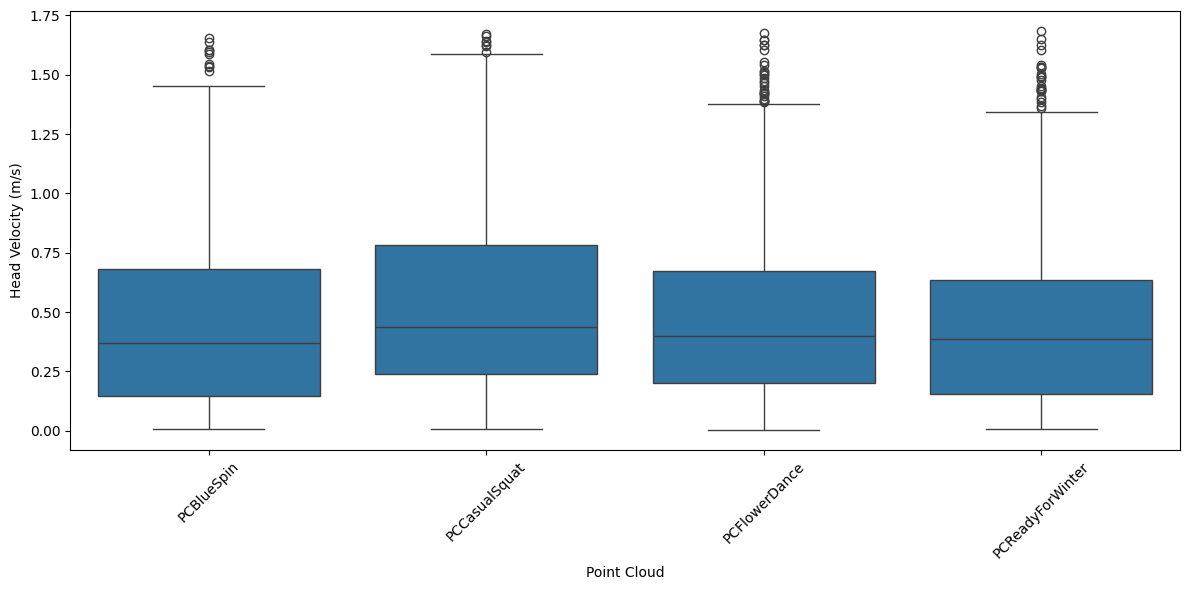

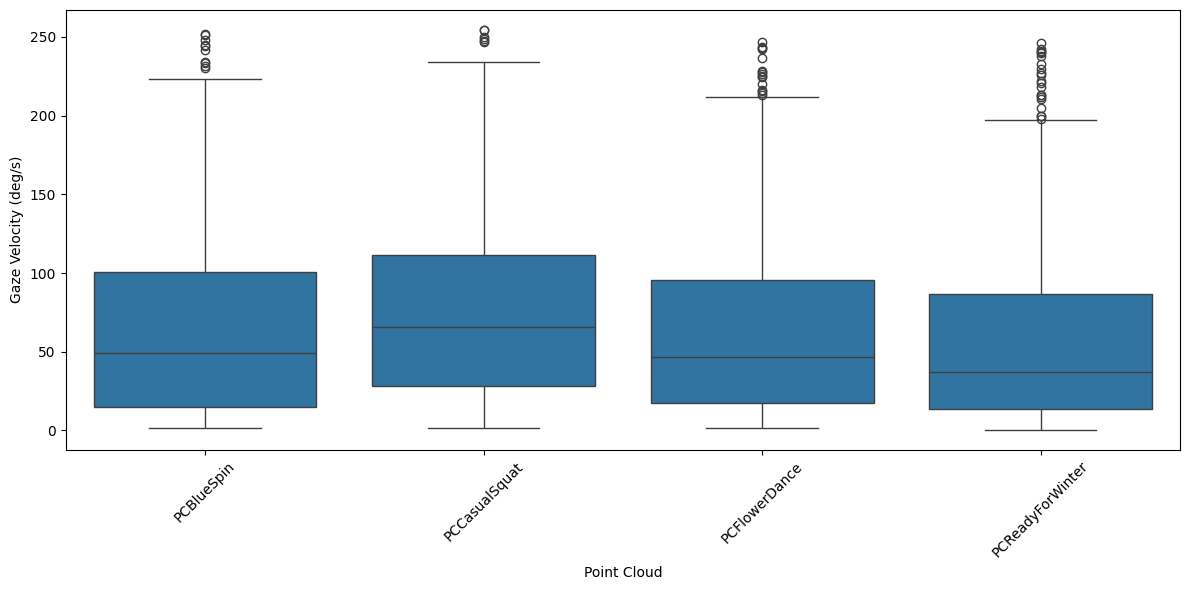

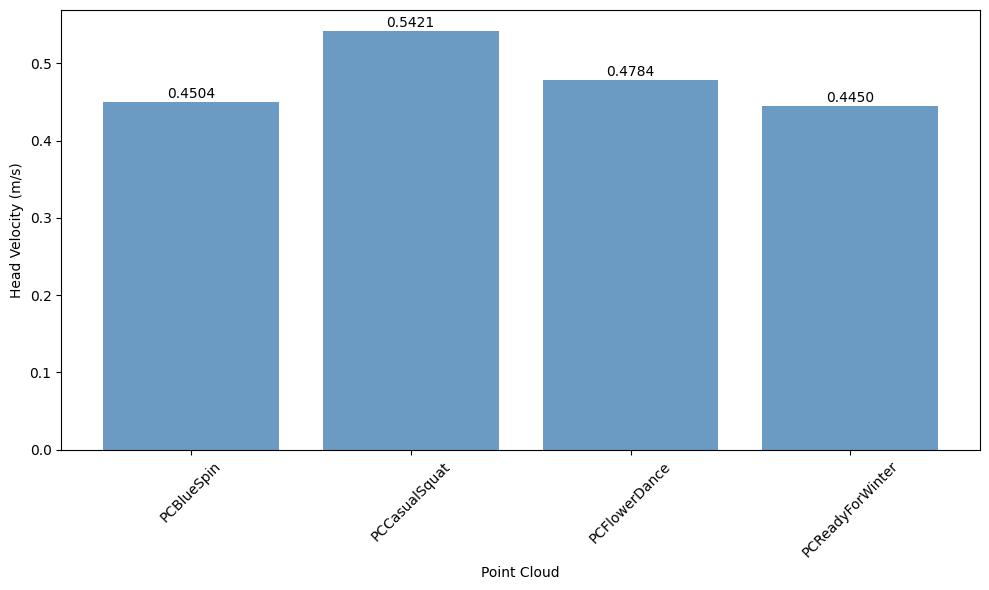

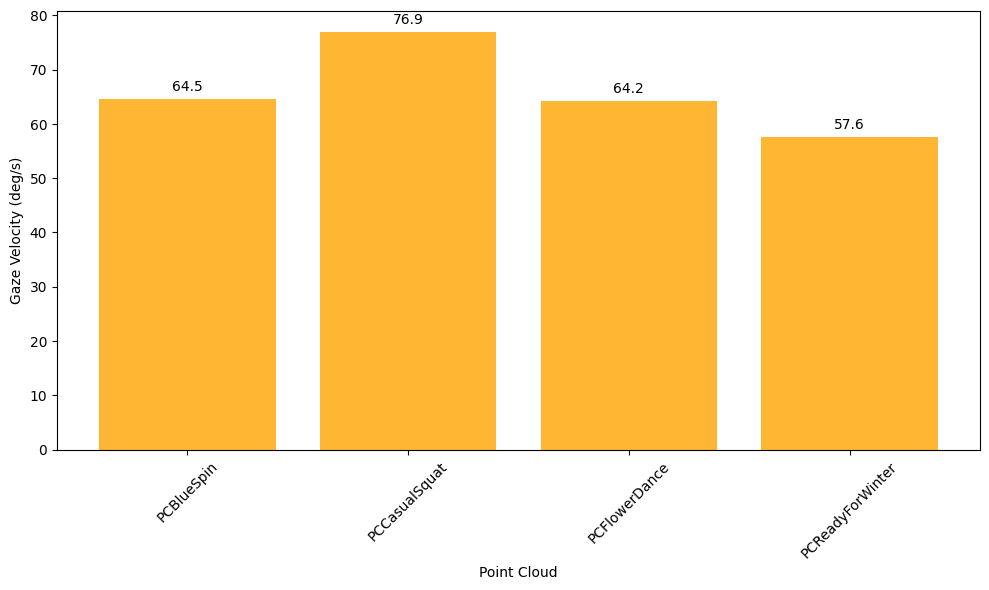


Point clouds ranked by head movement (highest to lowest):
1. PCCasualSquat: 0.5421 m/s
2. PCFlowerDance: 0.4784 m/s
3. PCBlueSpin: 0.4504 m/s
4. PCReadyForWinter: 0.4450 m/s

Point clouds ranked by gaze movement (highest to lowest):
1. PCCasualSquat: 76.9 deg/s
2. PCBlueSpin: 64.5 deg/s
3. PCFlowerDance: 64.2 deg/s
4. PCReadyForWinter: 57.6 deg/s


In [20]:
# Plot movement analysis by point cloud type

# Head movement by point cloud - Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='pc_name', y='head_velocity_m_per_s')
# plt.title('Head Movement Velocity by Point Cloud')
plt.xlabel('Point Cloud')
plt.ylabel('Head Velocity (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'head_movement_by_pointcloud_boxplot.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'head_movement_by_pointcloud_boxplot.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Gaze movement by point cloud - Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=velocity_df, x='pc_name', y='gaze_velocity_deg_per_s')
# plt.title('Gaze Movement Velocity by Point Cloud')
plt.xlabel('Point Cloud')
plt.ylabel('Gaze Velocity (deg/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_by_pointcloud_boxplot.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'gaze_movement_by_pointcloud_boxplot.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Average head movement by point cloud - Bar chart
plt.figure(figsize=(10, 6))
pc_means = (
    velocity_df.groupby('pc_name')
    .agg({'head_velocity_m_per_s': 'mean', 'gaze_velocity_deg_per_s': 'mean'})
    .reset_index()
)

bars1 = plt.bar(
    pc_means['pc_name'], pc_means['head_velocity_m_per_s'], alpha=0.8, color='steelblue'
)
plt.xlabel('Point Cloud')
plt.ylabel('Head Velocity (m/s)')
# plt.title('Average Head Movement by Point Cloud')
plt.xticks(rotation=45)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.001,
        f'{height:.4f}',
        ha='center',
        va='bottom',
        fontsize=10,
    )
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'average_head_movement_by_pointcloud.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'average_head_movement_by_pointcloud.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Average gaze movement by point cloud - Bar chart
plt.figure(figsize=(10, 6))
bars2 = plt.bar(pc_means['pc_name'], pc_means['gaze_velocity_deg_per_s'], alpha=0.8, color='orange')
plt.xlabel('Point Cloud')
plt.ylabel('Gaze Velocity (deg/s)')
# plt.title('Average Gaze Movement by Point Cloud')
plt.xticks(rotation=45)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 1,
        f'{height:.1f}',
        ha='center',
        va='bottom',
        fontsize=10,
    )
plt.tight_layout()
plt.savefig(
    os.path.join(results_dir, 'average_gaze_movement_by_pointcloud.pdf'),
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    os.path.join(results_dir, 'average_gaze_movement_by_pointcloud.png'),
    dpi=300,
    bbox_inches='tight',
)
plt.show()

# Rank point clouds by movement
pc_rankings = pc_means.sort_values('head_velocity_m_per_s', ascending=False)
print('\nPoint clouds ranked by head movement (highest to lowest):')
for i, (_, row) in enumerate(pc_rankings.iterrows(), 1):
    print(f'{i}. {row["pc_name"]}: {row["head_velocity_m_per_s"]:.4f} m/s')

pc_rankings_gaze = pc_means.sort_values('gaze_velocity_deg_per_s', ascending=False)
print('\nPoint clouds ranked by gaze movement (highest to lowest):')
for i, (_, row) in enumerate(pc_rankings_gaze.iterrows(), 1):
    print(f'{i}. {row["pc_name"]}: {row["gaze_velocity_deg_per_s"]:.1f} deg/s')

In [21]:
# Save detailed results to CSV files
print('Saving detailed results...')

# 1. Participant classifications
participant_classifications.to_csv(
    os.path.join(results_dir, 'participant_movement_classifications.csv'), index=False
)

# 2. Velocity data with categories
velocity_with_categories.to_csv(
    os.path.join(results_dir, 'velocity_data_with_categories.csv'), index=False
)

# 3. Summary statistics by category
category_summary = (
    velocity_with_categories.groupby('overall_movement_category')
    .agg(
        {
            'head_velocity_m_per_s': ['count', 'mean', 'std', 'min', 'max'],
            'gaze_velocity_deg_per_s': ['count', 'mean', 'std', 'min', 'max'],
        }
    )
    .round(6)
)
category_summary.to_csv(os.path.join(results_dir, 'movement_summary_by_category.csv'))

# 4. Summary statistics by point cloud
pc_summary = (
    velocity_df.groupby('pc_name')
    .agg(
        {
            'head_velocity_m_per_s': ['count', 'mean', 'std', 'min', 'max'],
            'gaze_velocity_deg_per_s': ['count', 'mean', 'std', 'min', 'max'],
        }
    )
    .round(6)
)
pc_summary.to_csv(os.path.join(results_dir, 'movement_summary_by_pointcloud.csv'))

# 5. Correlation analysis results (updated with both Pearson and Spearman)
correlation_results = pd.DataFrame(
    {
        'Category': ['Overall'] + categories,
        'Pearson_Correlation': [pearson_corr] + pearson_correlations,
        'Spearman_Correlation': [spearman_corr] + spearman_correlations,
        'Sample_Size': [len(velocity_df)]
        + [
            len(
                velocity_with_categories[
                    velocity_with_categories['overall_movement_category'] == cat
                ]
            )
            for cat in categories
        ],
    }
)
correlation_results.to_csv(os.path.join(results_dir, 'head_gaze_correlations.csv'), index=False)

# 6. Statistical test results
statistical_results = pd.DataFrame(
    {
        'Test': ['Head Movement ANOVA', 'Gaze Movement ANOVA'],
        'F_Statistic': [f_stat_head, f_stat_gaze],
        'P_Value': [p_val_head, p_val_gaze],
        'Significant': [p_val_head < 0.05, p_val_gaze < 0.05],
    }
)
statistical_results.to_csv(os.path.join(results_dir, 'statistical_test_results.csv'), index=False)

print('Results saved to the following files:')
for file in [
    'participant_movement_classifications.csv',
    'velocity_data_with_categories.csv',
    'movement_summary_by_category.csv',
    'movement_summary_by_pointcloud.csv',
    'head_gaze_correlations.csv',
    'statistical_test_results.csv',
]:
    print(f'- {file}')

Saving detailed results...
Results saved to the following files:
- participant_movement_classifications.csv
- velocity_data_with_categories.csv
- movement_summary_by_category.csv
- movement_summary_by_pointcloud.csv
- head_gaze_correlations.csv
- statistical_test_results.csv


/tmp/ipykernel_11247/2791451536.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  velocity_with_categories.groupby('overall_movement_category')


In [22]:
print(f'\n8. GENERATED FILES:')
generated_files = [
    # Figure files
    'outlier_filtering_comparison.pdf',
    'outlier_filtering_comparison.png',
    'head_movement_average.pdf',
    'head_movement_average.png',
    'head_movement_distribution.pdf',
    'head_movement_distribution.png',
    'gaze_movement_average.pdf',
    'gaze_movement_average.png',
    'gaze_movement_distribution.pdf',
    'gaze_movement_distribution.png',
    'head_movement_classification.pdf',
    'head_movement_classification.png',
    'gaze_movement_classification.pdf',
    'gaze_movement_classification.png',
    'head_vs_gaze_scatter.pdf',
    'head_vs_gaze_scatter.png',
    'average_head_velocity_by_category.pdf',
    'average_head_velocity_by_category.png',
    'average_gaze_velocity_by_category.pdf',
    'average_gaze_velocity_by_category.png',
    'head_movement_over_time_by_category.pdf',
    'head_movement_over_time_by_category.png',
    'gaze_movement_over_time_by_category.pdf',
    'gaze_movement_over_time_by_category.png',
    'head_movement_over_time_by_pointcloud.pdf',
    'head_movement_over_time_by_pointcloud.png',
    'gaze_movement_over_time_by_pointcloud.pdf',
    'gaze_movement_over_time_by_pointcloud.png',
    'individual_head_trajectories_by_pointcloud.pdf',
    'individual_head_trajectories_by_pointcloud.png',
    'individual_gaze_trajectories_by_pointcloud.pdf',
    'individual_gaze_trajectories_by_pointcloud.png',
    'head_velocity_distribution_by_category.pdf',
    'head_velocity_distribution_by_category.png',
    'gaze_velocity_distribution_by_category.pdf',
    'gaze_velocity_distribution_by_category.png',
    'head_vs_gaze_overall_correlation.pdf',
    'head_vs_gaze_overall_correlation.png',
    'head_vs_gaze_by_category.pdf',
    'head_vs_gaze_by_category.png',
    'correlation_by_category.pdf',
    'correlation_by_category.png',
    'summary_statistics_table.pdf',
    'summary_statistics_table.png',
    'head_movement_by_pointcloud_boxplot.pdf',
    'head_movement_by_pointcloud_boxplot.png',
    'gaze_movement_by_pointcloud_boxplot.pdf',
    'gaze_movement_by_pointcloud_boxplot.png',
    'average_head_movement_by_pointcloud.pdf',
    'average_head_movement_by_pointcloud.png',
    'average_gaze_movement_by_pointcloud.pdf',
    'average_gaze_movement_by_pointcloud.png',
    # CSV files
    'participant_movement_classifications.csv',
    'velocity_data_with_categories.csv',
    'movement_summary_by_category.csv',
    'movement_summary_by_pointcloud.csv',
    'head_gaze_correlations.csv',
    'statistical_test_results.csv',
]


8. GENERATED FILES:
